In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

2025-05-02 23:48:55.039591: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746229735.233560      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746229735.284646      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Input, Activation, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Activation, Dropout, Dense, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K



In [4]:

from sklearn.tree import DecisionTreeClassifier

In [5]:
import gdown

drive_link = 'https://drive.google.com/file/d/1-1vVh7moyW_eBKl_GL-TDILl-LnqMYk0/view?usp=sharing'

file_id = drive_link.split('/d/')[1].split('/')[0]
gdown_url = f'https://drive.google.com/uc?id={file_id}'

output_file = 'sepsis_data.csv'
gdown.download(gdown_url, output_file, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1-1vVh7moyW_eBKl_GL-TDILl-LnqMYk0
From (redirected): https://drive.google.com/uc?id=1-1vVh7moyW_eBKl_GL-TDILl-LnqMYk0&confirm=t&uuid=51408699-1795-4c59-aaf5-a9ffb30709a7
To: /kaggle/working/sepsis_data.csv
100%|██████████| 779M/779M [00:06<00:00, 116MB/s]  


'sepsis_data.csv'

In [6]:
print("done")

done


In [7]:
# Load and preprocess data
def load_and_preprocess_data(filepath):
    
    print(" Loading data.")
    # Read column names first to set datatypes efficiently
    dtype_dict = {col: 'float32' for col in pd.read_csv(filepath, nrows=1).columns 
                if col not in ['Patient_ID', 'SepsisLabel', 'ICULOS']}
    dtype_dict.update({'Patient_ID': 'str', 'SepsisLabel': 'int8', 'ICULOS': 'int16'})
    
    # Use chunks for more memory-efficient loading of large files
    df = pd.read_csv(filepath, dtype=dtype_dict)
    df = df.sort_values(['Patient_ID', 'ICULOS'])
    
    # Handle missing values - simplified approach
    cols_to_impute = [col for col in df.columns if col not in ['Patient_ID', 'SepsisLabel', 'ICULOS']]
    
    # First forward fill within patient groups
    df[cols_to_impute] = df.groupby('Patient_ID')[cols_to_impute].transform(lambda x: x.ffill())
    
    # Then backward fill remaining values
    df[cols_to_impute] = df.groupby('Patient_ID')[cols_to_impute].transform(lambda x: x.bfill())
    
    # Finally fill any remaining NaNs with 0
    df[cols_to_impute] = df[cols_to_impute].fillna(0)
    
    print("Initial class distribution:")
    print(df['SepsisLabel'].value_counts())
    return df

In [ ]:
# Create patient sequences
def create_patient_sequences(df, sequence_length=10):

    print(f"\n[STEP 2] Creating sequences (length={sequence_length})")
    
    sequences = []
    labels = []
    
    feature_cols = [col for col in df.columns if col not in ['Patient_ID', 'SepsisLabel', 'ICULOS']]
    
    # Process patients one by one to manage memory
    for pid, group in df.groupby('Patient_ID'):
        # Extract features and labels
        features = group[feature_cols].values
        sepsis_labels = group['SepsisLabel'].values
        
        # Handle sequences shorter than desired length
        if len(features) < sequence_length:
            # Pad with zeros at the beginning (representing historical data we don't have)
            pad_len = sequence_length - len(features)
            features = np.vstack([np.zeros((pad_len, features.shape[1])), features])
            sepsis_labels = np.concatenate([np.zeros(pad_len), sepsis_labels])
        
        # Create sliding windows - optimized to avoid unnecessary operations
        for i in range(0, len(features) - sequence_length + 1, 1):  # Step size of 1
            seq = features[i:i+sequence_length]
            # Label as 1 if sepsis occurs within the sequence window
            label = 1 if np.any(sepsis_labels[i:i+sequence_length] > 0) else 0
            sequences.append(seq)
            labels.append(label)
    
    X = np.array(sequences, dtype=np.float32)  
    y = np.array(labels, dtype=np.int8)
    
    print(f"Created {len(X)} sequences")
    print(f"Class 0: {np.sum(y == 0)}, Class 1: {np.sum(y == 1)}")
    return X, y, feature_cols

In [ ]:
# Corrected Decision Tree based undersampling
def decision_tree_undersampling(X, y, target_samples=35000):
    """Undersample majority class using decision tree predictions"""
    print(f"\nUndersampling majority class to {target_samples} samples...")
    
    # Get indices of majority class
    majority_indices = np.where(y == 0)[0]
    
    # If we already have fewer samples than target, return as is
    if len(majority_indices) <= target_samples:
        return X, y
    
    # Randomly select subset for efficiency
    np.random.shuffle(majority_indices)
    subset_indices = majority_indices[:min(50000, len(majority_indices))]  # Limit for efficiency
    
    # Flatten the time steps for feature importance calculation
    X_flattened = X[subset_indices].reshape(-1, X.shape[-1])
    y_flattened = np.repeat(y[subset_indices], X.shape[1])
    
    # Train decision tree to find most important samples
    dt = DecisionTreeClassifier(max_depth=5, random_state=42)
    dt.fit(X_flattened, y_flattened)
    
    # Get feature importances for each sample
    sample_importances = []
    for idx in subset_indices:
        # Calculate average feature importance across all time steps
        importance = np.mean([dt.feature_importances_ for _ in range(X.shape[1])], axis=0)
        sample_importances.append(np.sum(importance))
    
    # Select samples with highest importance scores
    selected_indices = np.argsort(sample_importances)[-target_samples:]
    
    # Combine with minority class
    minority_indices = np.where(y == 1)[0]
    final_indices = np.concatenate([subset_indices[selected_indices], minority_indices])
    
    return X[final_indices], y[final_indices]

def decision_tree_upsampling(X, y, target_samples=27000):
   
    print(f"\nUpsampling minority class to {target_samples} samples...")
    
    # Get indices of minority class
    minority_indices = np.where(y == 1)[0]
    
    # If we already have more samples than target, return as is
    if len(minority_indices) >= target_samples:
        return X, y
    
    # Calculate how many samples we need to generate
    num_to_generate = target_samples - len(minority_indices)
    
    # Flatten the time steps for feature importance calculation
    X_flattened = X.reshape(-1, X.shape[-1])
    y_flattened = np.repeat(y, X.shape[1])
    
    # Train decision tree to understand feature relationships
    dt = DecisionTreeClassifier(max_depth=5, random_state=42)
    dt.fit(X_flattened, y_flattened)
    
    # Generate synthetic samples based on feature distributions
    synthetic_samples = []
    for _ in range(num_to_generate):
        # Randomly select a minority sample to base new sample on
        base_sample = X[np.random.choice(minority_indices)]
        
        # Create synthetic sample by perturbing features based on importance
        synthetic_sample = base_sample.copy()
        for t in range(X.shape[1]):  # For each time step
            for f in range(X.shape[2]):  # For each feature
                if dt.feature_importances_[f] > 0.01:  # Only modify important features
                    # Add noise proportional to feature importance
                    noise = np.random.normal(0, dt.feature_importances_[f] * 0.1)
                    synthetic_sample[t, f] += noise
        
        synthetic_samples.append(synthetic_sample)
    
    # Convert list of synthetic samples to numpy array with same shape as X
    synthetic_samples = np.array(synthetic_samples)
    
    # Combine real and synthetic samples
    X_upsampled = np.concatenate([X, synthetic_samples])
    y_upsampled = np.concatenate([y, np.ones(num_to_generate, dtype=np.int8)])
    
    return X_upsampled, y_upsampled

In [10]:
# Prepare balanced dataset
def prepare_balanced_dataset(X, y, target_class0=35000, target_class1=27000):
    """Prepare a balanced dataset with exact specified class counts"""
    print("\n[STEP 3] Preparing balanced dataset...")
    
    # First, undersample class 0 to exact target
    X_undersampled, y_undersampled = decision_tree_undersampling(X, y, target_samples=target_class0)
    
    # Then, upsample class 1 to exact target
    X_balanced, y_balanced = decision_tree_upsampling(X_undersampled, y_undersampled, target_samples=target_class1)
    
    # Shuffle the dataset
    indices = np.arange(len(y_balanced))
    np.random.shuffle(indices)
    X_balanced = X_balanced[indices]
    y_balanced = y_balanced[indices]
    
    print(f"Final balanced dataset - Class 0: {np.sum(y_balanced == 0)}, Class 1: {np.sum(y_balanced == 1)}")
    return X_balanced, y_balanced


In [ ]:
def custom_train_test_split_with_balancing(X, y, train_class0=35000, train_class1=27000):
  
    print("\n[STEP 4] Custom train-test split with balanced classes...")
    
    # Get indices for each class
    indices_class0 = np.where(y == 0)[0]
    indices_class1 = np.where(y == 1)[0]
    
    print(f"Total samples - Class 0: {len(indices_class0)}, Class 1: {len(indices_class1)}")
    
    # Make sure we don't request more samples than available
    train_class0 = min(train_class0, len(indices_class0))
    train_class1 = min(train_class1, len(indices_class1))
    
    # Randomly select indices for training set for each class
    np.random.shuffle(indices_class0)
    np.random.shuffle(indices_class1)
    
    train_indices_class0 = indices_class0[:train_class0]
    train_indices_class1 = indices_class1[:train_class1]
    
    # Remaining indices go to test set
    test_indices_class0 = indices_class0[train_class0:]
    test_indices_class1 = indices_class1[train_class1:]
    
    # Combine indices
    train_indices = np.concatenate([train_indices_class0, train_indices_class1])
    test_indices = np.concatenate([test_indices_class0, test_indices_class1])
    
    # Shuffle the training indices
    np.random.shuffle(train_indices)
    
    # Create the training and test sets
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    print(f"Training set - Class 0: {np.sum(y_train == 0)}, Class 1: {np.sum(y_train == 1)}")
    print(f"Test set - Class 0: {np.sum(y_test == 0)}, Class 1: {np.sum(y_test == 1)}")
    
    return X_train, X_test, y_train, y_test


In [ ]:

def utility_loss(y_true, y_pred, t_star=6):
   
    # Calculate the penalty for early predictions (if t < t_star - 6)
    early_penalty = -0.05 * K.cast(K.less(y_true, t_star - 6), K.floatx())  # Early penalty if predicted too soon
    
    # Calculate the penalty for late predictions (if t > t_star + 9)
    late_penalty = (y_true - t_star + 6) / 6  # Penalty for late predictions
    
    # Binary cross-entropy loss (standard classification loss)
    bce_loss = K.binary_crossentropy(y_true, y_pred)
    
    # Combine binary cross-entropy with utility penalties (early and late penalties)
    total_loss = bce_loss + early_penalty + late_penalty
    
    return total_loss


In [ ]:

def build_tcn_model(input_shape):
    
    inputs = Input(shape=input_shape)
    
    # Layer 1 Convolutional Layer with 128 filters, kernel size 3, and dilation rate 1
    x = Conv1D(128, 3, dilation_rate=1, padding='causal')(inputs)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)

    
    # Layer 2 Convolutional Layer with 256 filters, kernel size 3, and dilation rate 2
    x = Conv1D(256, 3, dilation_rate=2, padding='causal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)
    
   
    
    # Layer 3 Convolutional Layer with 512 filters, kernel size 3, and dilation rate 4
    x = Conv1D(512, 3, dilation_rate=4, padding='causal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)
    
    x = GlobalMaxPooling1D()(x)
    
    outputs = Dense(1, activation='sigmoid')(x)
    
    # Build the model
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=Adam(),
        loss=utility_loss,  
        metrics=['accuracy', 'AUC'] 
    )
    
    return model


In [ ]:
# Evaluation function
def evaluate_model(model, X, y, set_name="Test"):
   
    print(f"\n{set_name} Set Evaluation:")
    
    y_prob = model.predict(X)
    y_pred = (y_prob > 0.5).astype(int)
    
    # Classification report
    print(classification_report(y, y_pred))
    
    # AUC score
    auc = roc_auc_score(y, y_prob)
    print(f"ROC AUC: {auc:.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=['No Sepsis', 'Sepsis'],
               yticklabels=['No Sepsis', 'Sepsis'])
    plt.title(f'Confusion Matrix - {set_name} Set')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [16]:
# Main execution
filepath = "/kaggle/working/sepsis_data.csv"
df = load_and_preprocess_data(filepath)
X, y, feature_cols = create_patient_sequences(df, sequence_length=10)

 Loading data.
Initial class distribution:
SepsisLabel
0    1510640
1      26715
Name: count, dtype: int64

[STEP 2] Creating sequences (length=10)
Created 1179170 sequences
Class 0: 1157517, Class 1: 21653


In [17]:
# Step 3: Balance dataset
X_balanced, y_balanced = prepare_balanced_dataset(X, y, target_class0=50022, target_class1=35000)
X_train, X_test, y_train, y_test = custom_train_test_split_with_balancing(X_balanced, y_balanced, train_class0=35000, train_class1=27000)


[STEP 3] Preparing balanced dataset...

Undersampling majority class to 50022 samples...

Upsampling minority class to 35000 samples...
Final balanced dataset - Class 0: 50000, Class 1: 35000

[STEP 4] Custom train-test split with balanced classes...
Total samples - Class 0: 50000, Class 1: 35000
Training set - Class 0: 35000, Class 1: 27000
Test set - Class 0: 15000, Class 1: 8000


In [18]:
# Feature scaling
print("\n Scaling features")
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)


 Scaling features


In [19]:
# Step 6: Build model
print("\n[STEP 6] Building model...")
model = build_tcn_model((X_train.shape[1], X_train.shape[2]))
model.summary()

# Step 7: Train model
print("\n[STEP 7] Training model...")
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_auc', patience=5, mode='max', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=64,
    callbacks=callbacks,
    class_weight={0: 1, 1: 1.5},
    verbose=1
)


[STEP 6] Building model...


I0000 00:00:1746230103.254390      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 10, 55)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 10, 128)             │          21,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 10, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 10, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 10, 512)             │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 10, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 512)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 514,049 (1.96 MB)

 Trainable params: 514,049 (1.96 MB)

 Non-trainable params: 0 (0.00 B)


[STEP 7] Training model...
Epoch 1/30


I0000 00:00:1746230107.198840     139 service.cc:148] XLA service 0x797e54004990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746230107.199386     139 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746230107.506596     139 cuda_dnn.cc:529] Loaded cuDNN version 90300


 53/969 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.6219 - accuracy: 0.5656 - loss: 0.9522

I0000 00:00:1746230110.843589     139 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


969/969 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - AUC: 0.7442 - accuracy: 0.6754 - loss: 0.8367 - val_AUC: 0.8076 - val_accuracy: 0.7015 - val_loss: 0.6413 - learning_rate: 0.0010
Epoch 2/30
969/969 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8097 - accuracy: 0.7268 - loss: 0.7545 - val_AUC: 0.8271 - val_accuracy: 0.7286 - val_loss: 0.6047 - learning_rate: 0.0010
Epoch 3/30
969/969 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8301 - accuracy: 0.7435 - loss: 0.7223 - val_AUC: 0.8459 - val_accuracy: 0.7478 - val_loss: 0.5781 - learning_rate: 0.0010
Epoch 4/30
969/969 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8454 - accuracy: 0.7559 - loss: 0.6960 - val_AUC: 0.8598 - val_accuracy: 0.7608 - val_loss: 0.5611 - learning_rate: 0.0010
Epoch 5/30
969/969 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8592 - accuracy: 0.7712 - loss: 0.6709 - val_AUC: 0.8738 - val_accuracy: 0.7748 - val_loss: 0.5394 - learning_rate: 0.0010
Epoch 6/30
969/969 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8727 - accuracy: 0.7829 - los


[STEP 8] Plotting training metrics...


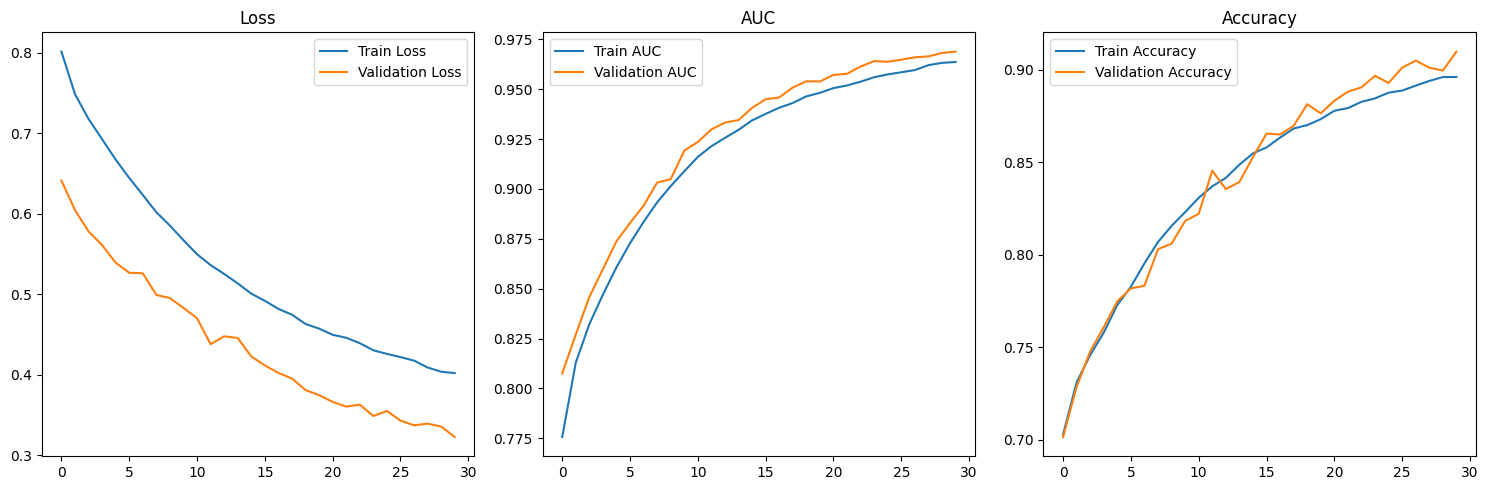


[STEP 9] Evaluating model...

Train Set Evaluation:
1938/1938 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     35000
           1       0.96      0.98      0.97     27000

    accuracy                           0.97     62000
   macro avg       0.97      0.97      0.97     62000
weighted avg       0.97      0.97      0.97     62000

ROC AUC: 0.9959


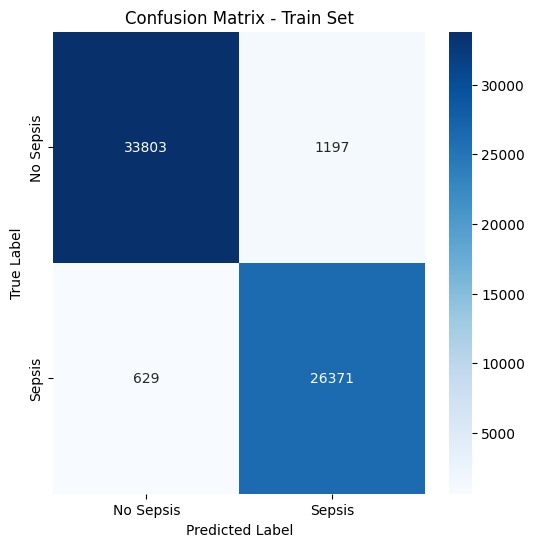


Test Set Evaluation:
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
              precision    recall  f1-score   support

           0       0.96      0.90      0.93     15000
           1       0.83      0.94      0.88      8000

    accuracy                           0.91     23000
   macro avg       0.90      0.92      0.90     23000
weighted avg       0.92      0.91      0.91     23000

ROC AUC: 0.9689


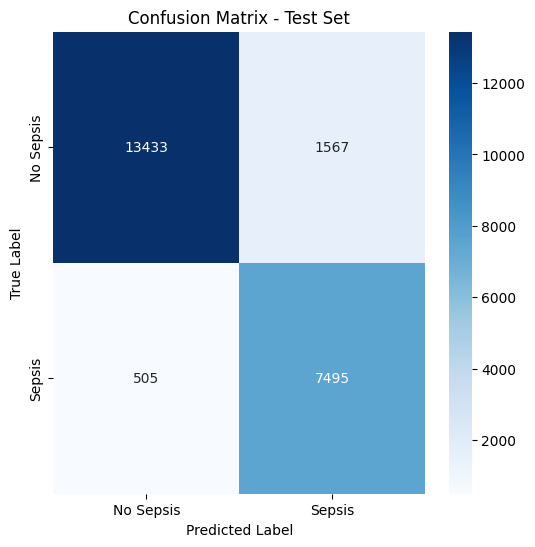

In [22]:
# Step 8: Plot training metrics
print("\n[STEP 8] Plotting training metrics...")
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()
    
plt.subplot(1, 3, 2)
plt.plot(history.history['AUC'], label='Train AUC')
plt.plot(history.history['val_AUC'], label='Validation AUC')
plt.title('AUC')
plt.legend()
    
plt.subplot(1, 3, 3)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
    
plt.tight_layout()
plt.show()
    
    # Step 9: Evaluate model
print("\n[STEP 9] Evaluating model...")
evaluate_model(model, X_train, y_train, "Train")
evaluate_model(model, X_test, y_test, "Test")

In [23]:
!pip install shap


# 

In [26]:
import shap
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
# import innvestigate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
import warnings
warnings.filterwarnings('ignore')
import shap


[SHAP ANALYSIS] Starting SHAP analysis for sepsis prediction model...

[STEP 8] Creating SHAP explainer with 100 background samples...
Using wrapped model for SHAP explanation
Error creating wrapped model: 'tuple' object has no attribute 'as_list'
Falling back to gradient explainer...

[STEP 9] Calculating SHAP values for 300 samples...
Error calculating SHAP values: in user code:

    File "/usr/local/lib/python3.11/dist-packages/shap/explainers/_gradient.py", line 217, in grad_graph  *
        phase = tf.keras.backend.learning_phase()

    AttributeError: module 'tensorflow.keras.backend' has no attribute 'learning_phase'

Using fallback calculation method...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


  0%|          | 0/300 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Fallback method failed: You are using LassoLarsIC in the case where the number of samples is smaller than the number of features. In this setting, getting a good estimate for the variance of the noise is not possible. Provide an estimate of the noise variance in the constructor.
Creating dummy SHAP values for demonstration...

[STEP 10] Analyzing SHAP values...


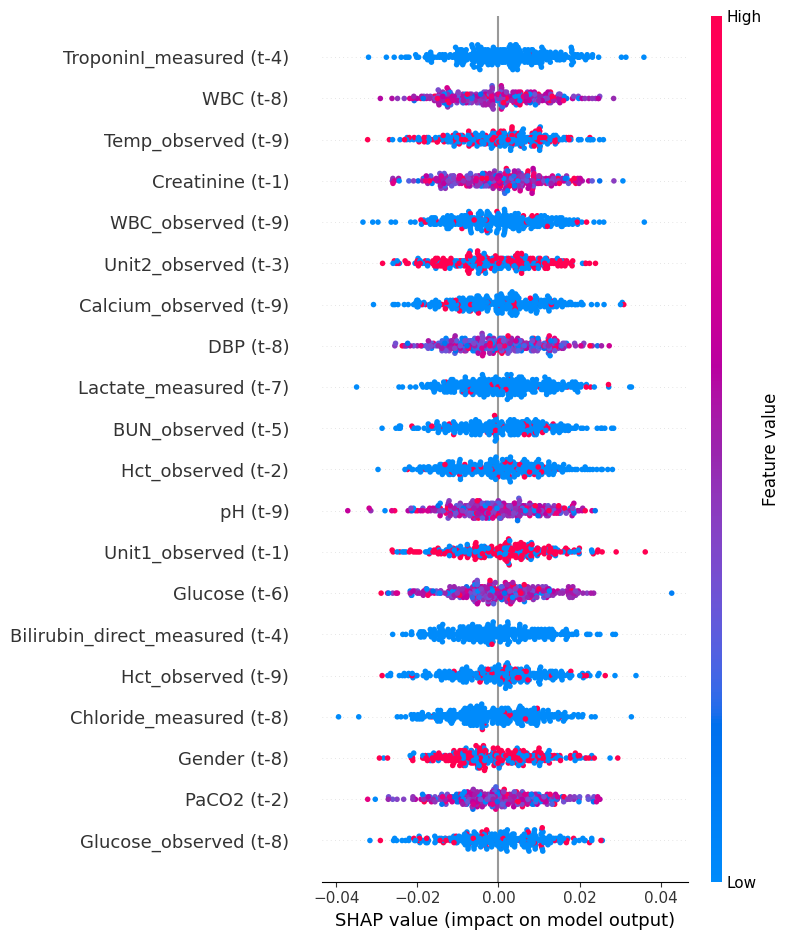

<Figure size 640x480 with 0 Axes>

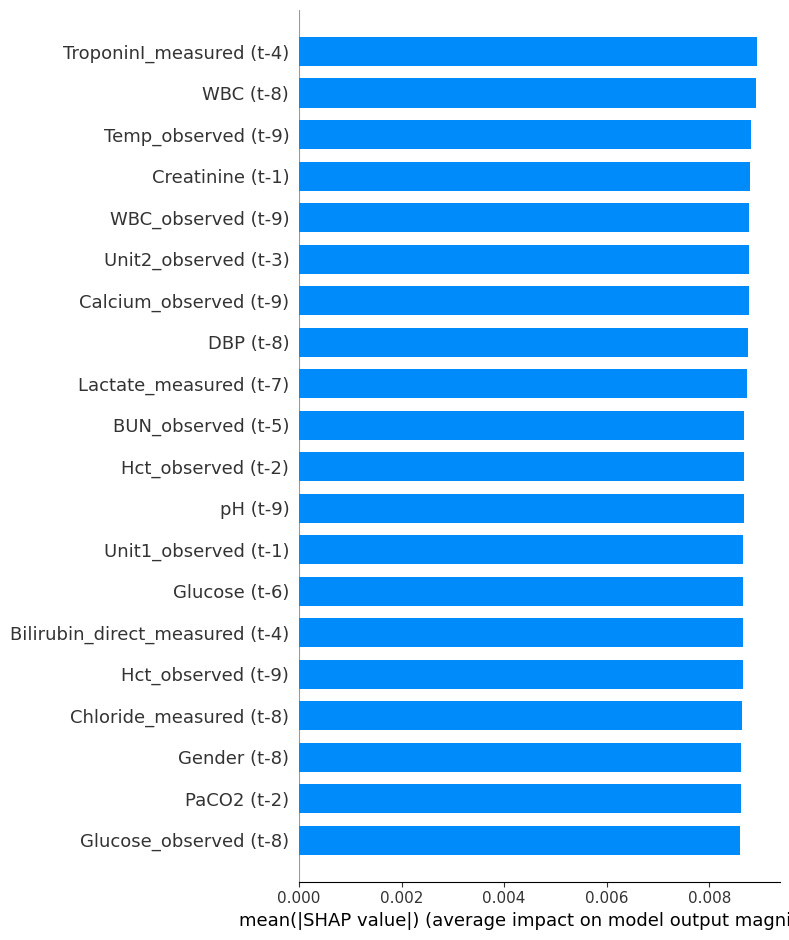

<Figure size 640x480 with 0 Axes>

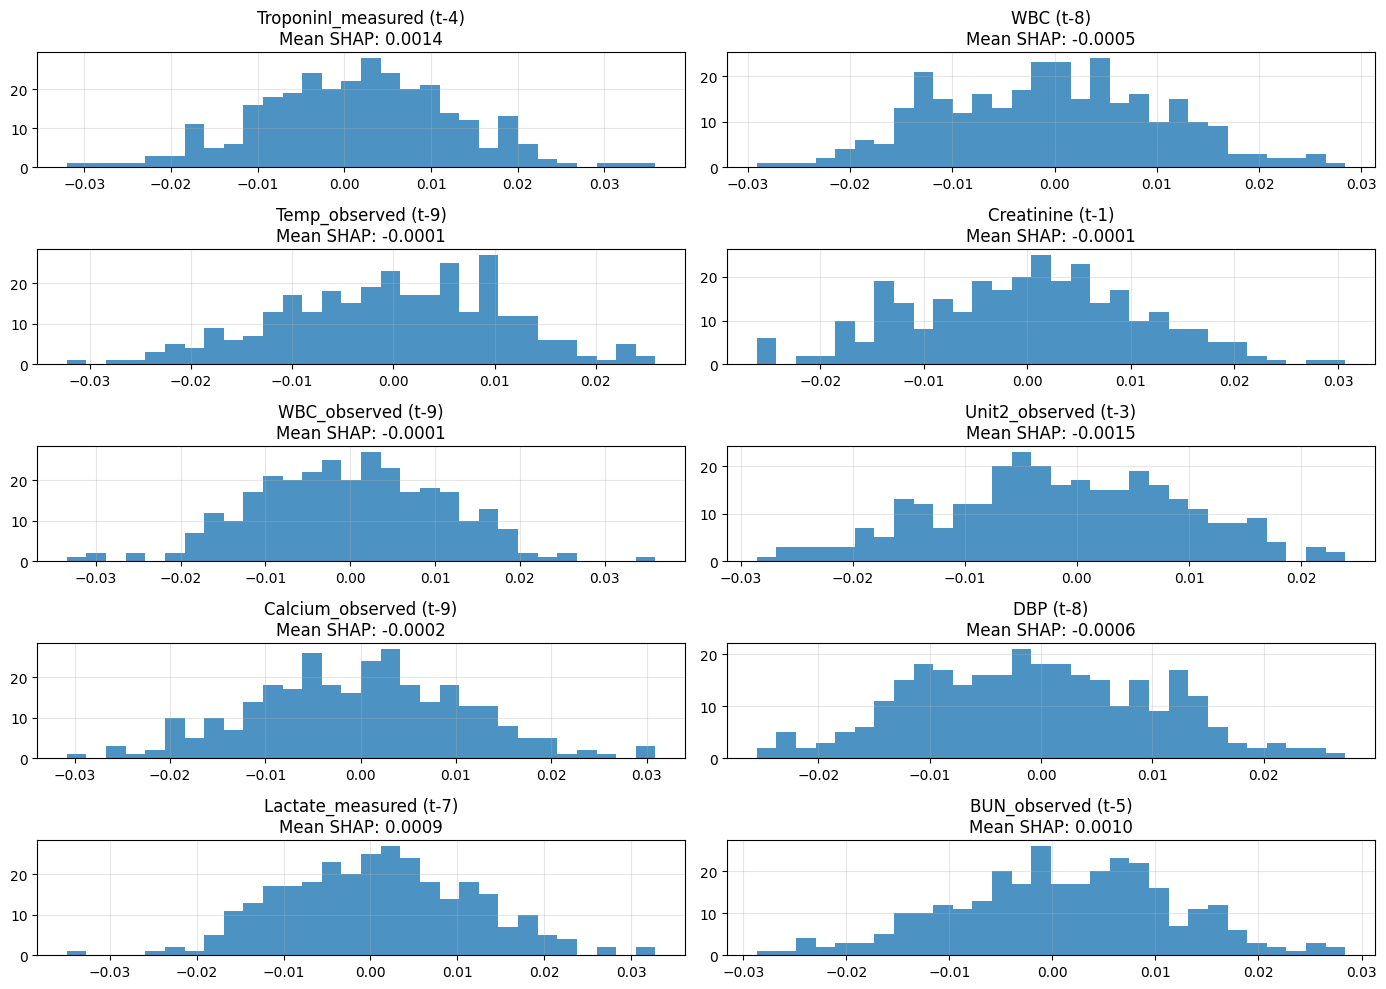

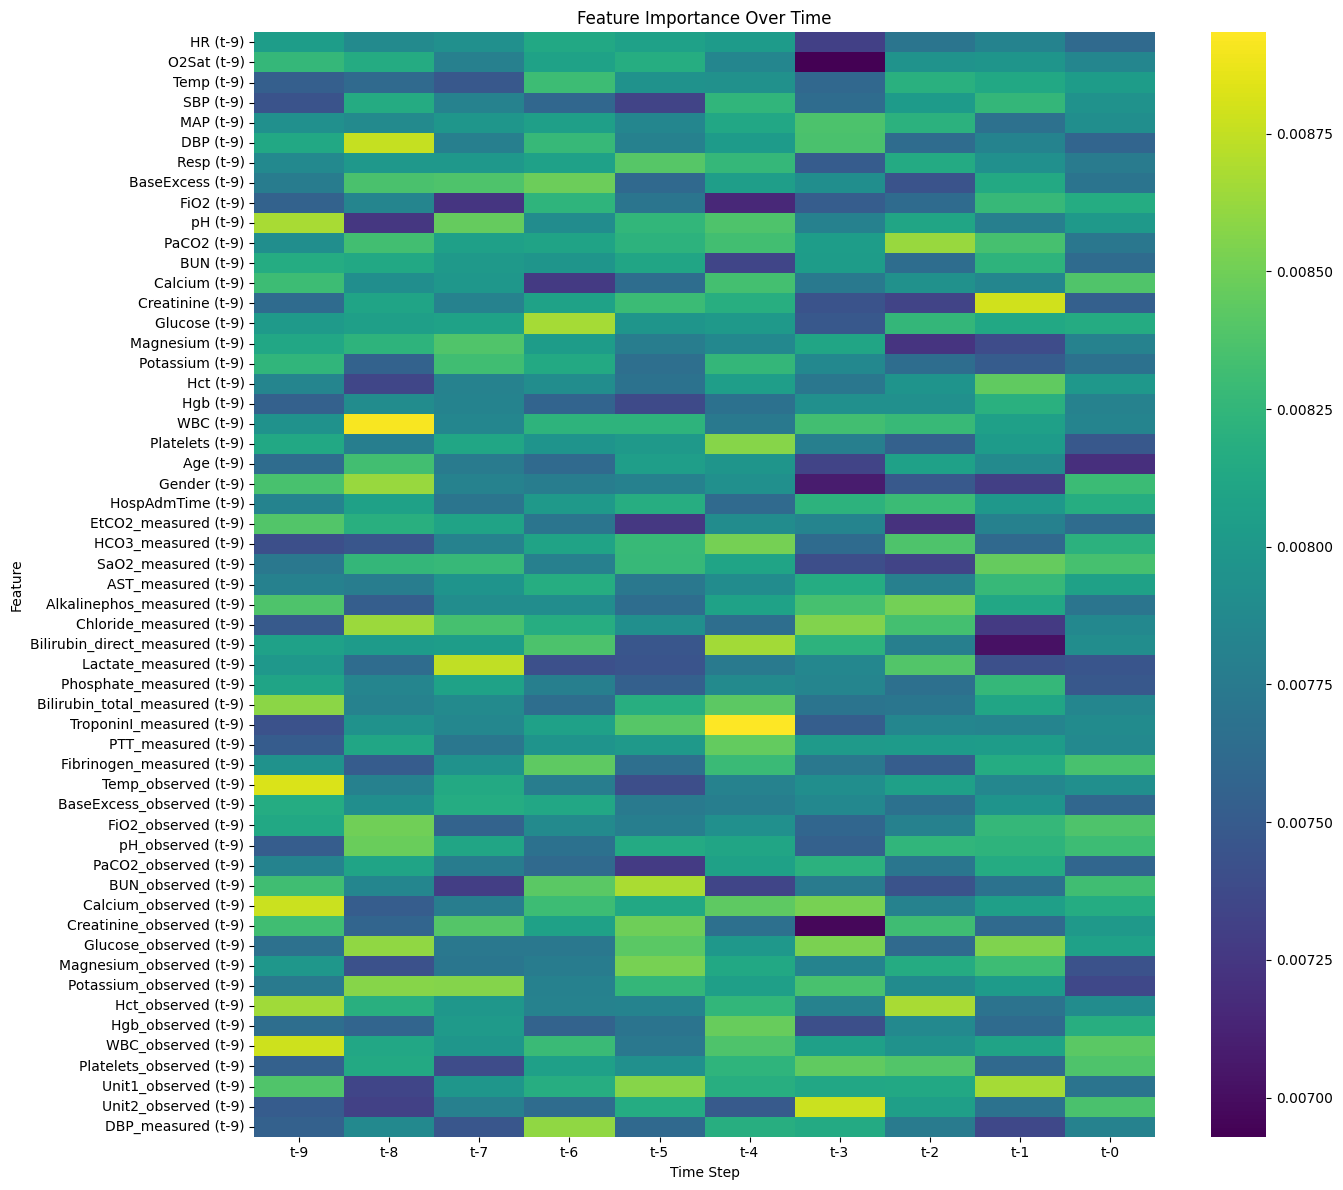


[STEP 11] Analyzing feature interactions...


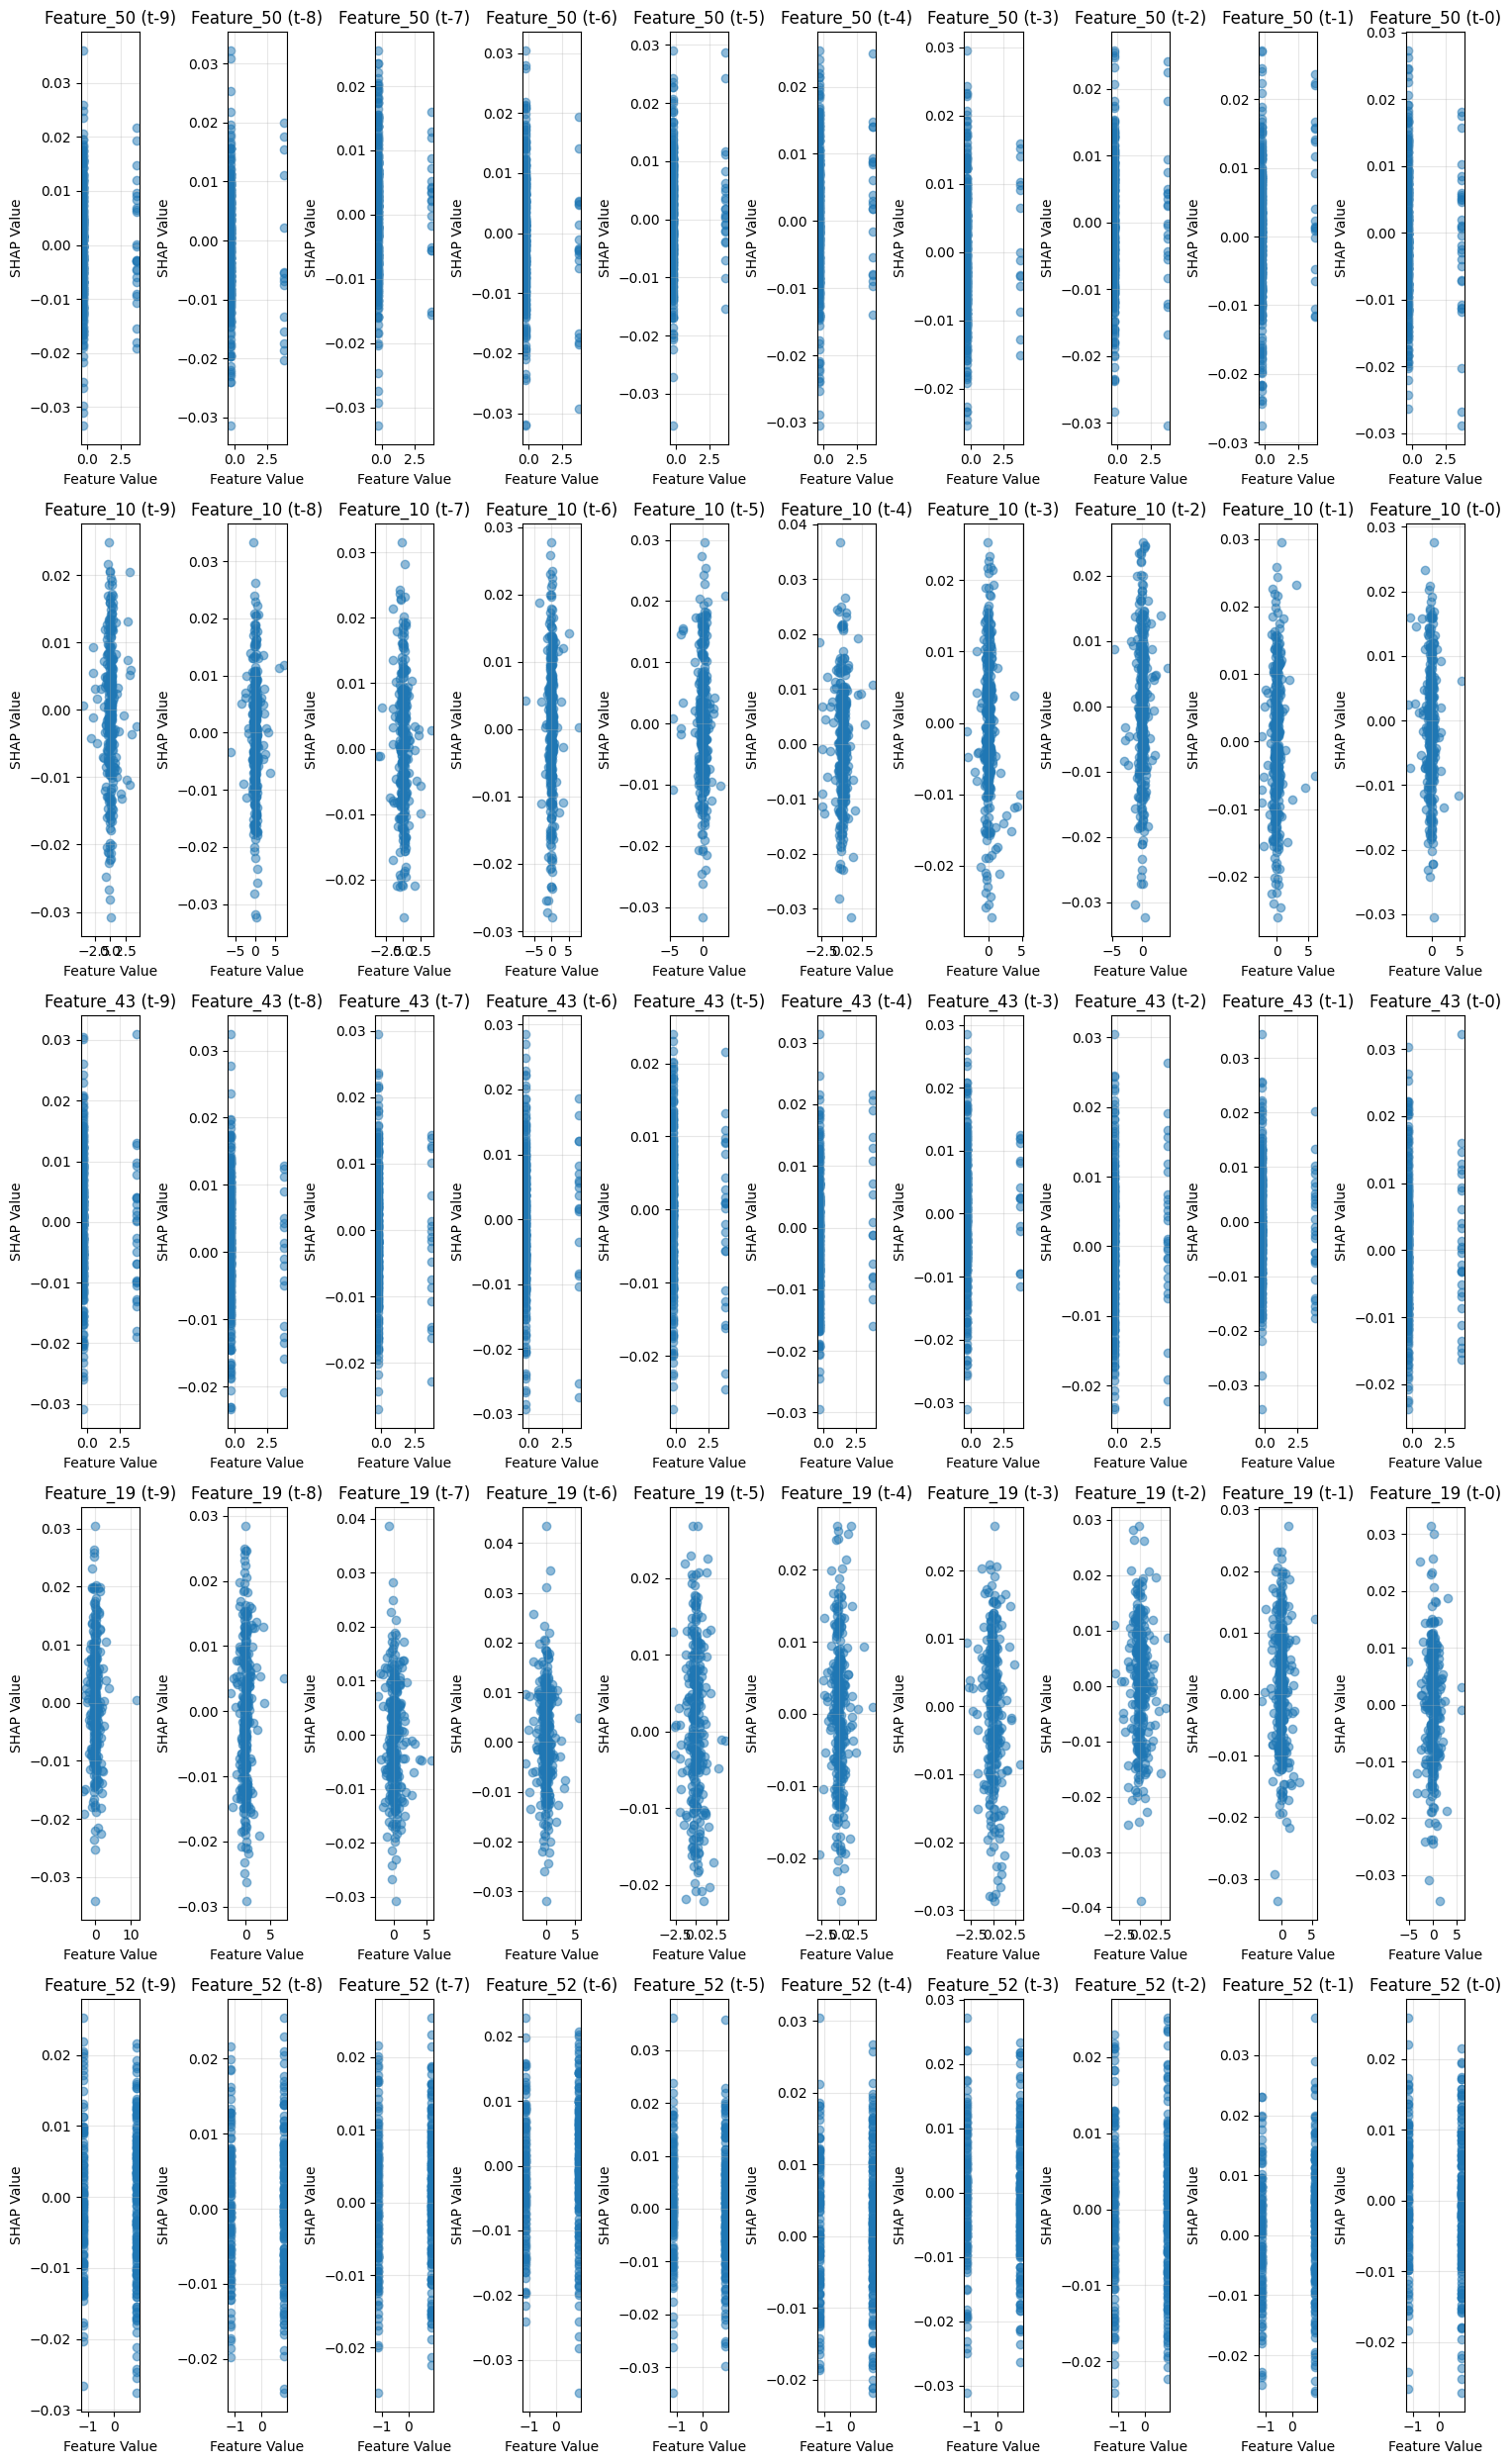

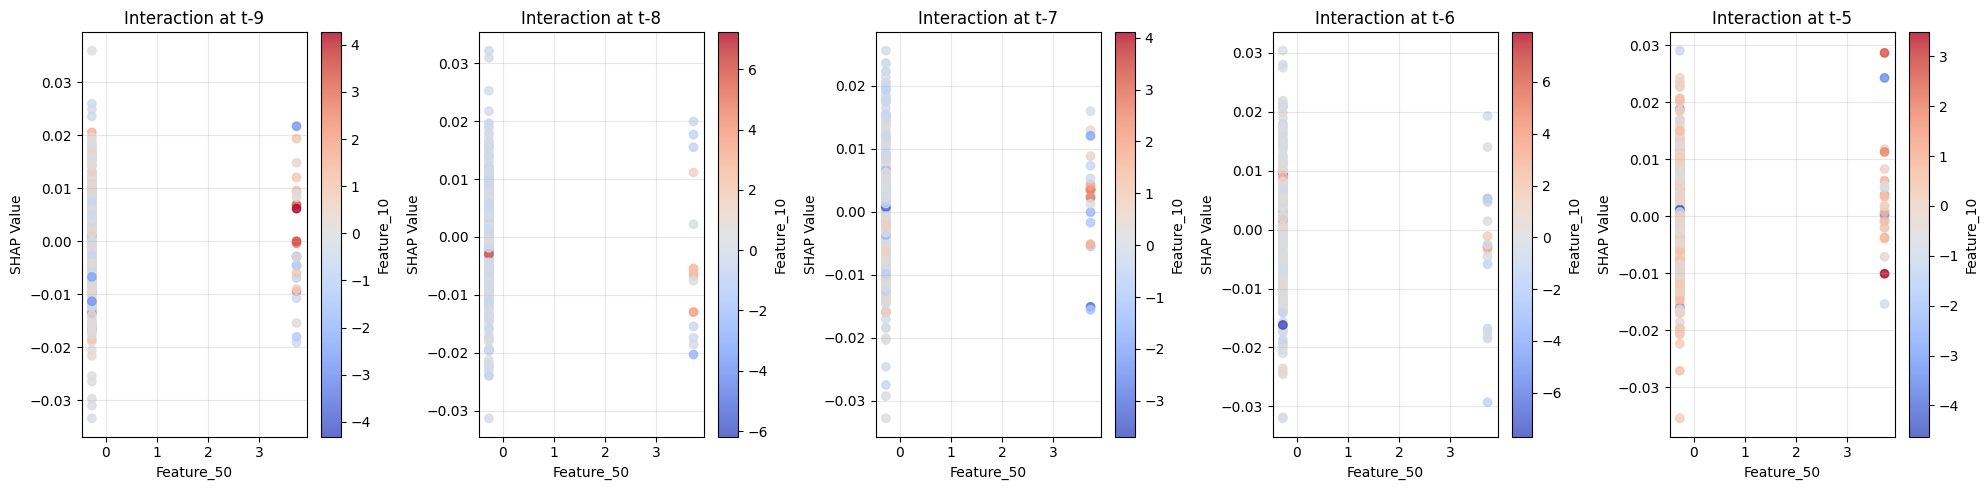


[SHAP ANALYSIS] Identifying clinical patterns...
Top 10 features with highest importance across all time steps:
1. WBC_observed
2. PaCO2
3. Calcium_observed
4. WBC
5. Unit1_observed
6. Glucose_observed
7. Hct_observed
8. Glucose
9. Potassium_observed
10. pH

Top features by time step (recent to older):
Time t-9: ['Temp_observed', 'WBC_observed', 'Calcium_observed']
Time t-8: ['WBC', 'DBP', 'Chloride_measured']
Time t-7: ['Lactate_measured', 'Potassium_observed', 'pH']
Time t-6: ['Glucose', 'DBP_measured', 'BaseExcess']
Time t-5: ['BUN_observed', 'Unit1_observed', 'Magnesium_observed']
Time t-4: ['TroponinI_measured', 'Bilirubin_direct_measured', 'Platelets']
Time t-3: ['Unit2_observed', 'Chloride_measured', 'Glucose_observed']
Time t-2: ['Hct_observed', 'PaCO2', 'Alkalinephos_measured']
Time t-1: ['Creatinine', 'Unit1_observed', 'Glucose_observed']
Time t-0: ['WBC_observed', 'Calcium', 'FiO2_observed']

[SHAP ANALYSIS] Analysis completed successfully!


In [ ]:


np.random.seed(42)
tf.random.set_seed(42)


def evaluate_model(model, X, y, set_name="Test"):
    """Evaluate model performance"""
    print(f"\n{set_name} Set Evaluation:")
    
    y_prob = model.predict(X)
    y_pred = (y_prob > 0.5).astype(int)
    
    # Classification report
    print(classification_report(y, y_pred))
    
    # AUC score
    auc = roc_auc_score(y, y_prob)
    print(f"ROC AUC: {auc:.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=['No Sepsis', 'Sepsis'],
               yticklabels=['No Sepsis', 'Sepsis'])
    plt.title(f'Confusion Matrix - {set_name} Set')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
def create_shap_explainer(model, X_train, feature_names, background_samples=100):
    
    print(f"\n[STEP 8] Creating SHAP explainer with {background_samples} background samples...")
    
  
    np.random.seed(42)  # For reproducibility
    background_idx = np.random.choice(X_train.shape[0], background_samples, replace=False)
    background = X_train[background_idx]
    
    try:
       
        input_shape = model.input_shape[1:] 
        
        input_layer = Input(shape=input_shape)
        
        output = model(input_layer)
        
        if isinstance(output, tuple):
            output = output[0]
    
        wrapped_model = Model(inputs=input_layer, outputs=output)
        
        tf.compat.v1.disable_eager_execution = lambda: None
        
        print("Using wrapped model for SHAP explanation")
        explainer = shap.DeepExplainer(wrapped_model, background)
    except Exception as e:
        print(f"Error creating wrapped model: {e}")
        print("Falling back to gradient explainer...")
        
       
        try:
            explainer = shap.GradientExplainer(model, background)
        except Exception as e2:
            print(f"Error with GradientExplainer: {e2}")
            print("Falling back to KernelExplainer (slower but more reliable)...")
            
            
          
            background_flat = background.reshape(background.shape[0], -1)
            
            def predict_fn(x):
              
                x_reshaped = x.reshape(-1, X_train.shape[1], X_train.shape[2])
                return model.predict(x_reshaped)
            
            explainer = shap.KernelExplainer(predict_fn, background_flat)
    
    full_feature_names = []
    for t in range(X_train.shape[1]): 
        for f in feature_names:
            full_feature_names.append(f"{f} (t-{X_train.shape[1]-t-1})")
    
    return explainer, full_feature_names

# Calculate SHAP values
def calculate_shap_values(explainer, X, num_samples=300):

    print(f"\n[STEP 9] Calculating SHAP values for {num_samples} samples...")
    
    np.random.seed(42)  # For reproducibility
    samples_idx = np.random.choice(X.shape[0], min(num_samples, X.shape[0]), replace=False)
    X_to_explain = X[samples_idx]
    
    try:
        if isinstance(explainer, shap.KernelExplainer):
            # Flatten the data for KernelExplainer
            X_to_explain_flat = X_to_explain.reshape(X_to_explain.shape[0], -1)
            shap_values = explainer.shap_values(X_to_explain_flat)
            
        
            if isinstance(shap_values, list):
             
                shap_values = shap_values[0]  
            
            shap_values = shap_values.reshape(X_to_explain.shape)
        else:
           
            shap_values = explainer.shap_values(X_to_explain)
            if isinstance(shap_values, list):
                shap_values = shap_values[0]
    except Exception as e:
        print(f"Error calculating SHAP values: {e}")
        print("Using fallback calculation method...")
  
        try:
          
            def predict_fn(x):
                return model.predict(x.reshape(-1, X.shape[1], X.shape[2]))
            
            X_flat = X_to_explain.reshape(X_to_explain.shape[0], -1)
            
      
            kernel_explainer = shap.KernelExplainer(predict_fn, X_flat[:10])
            
            shap_values = kernel_explainer.shap_values(X_flat, nsamples=100)
            
            if isinstance(shap_values, list):
                shap_values = shap_values[0]
            
            shap_values = shap_values.reshape(X_to_explain.shape)
        except Exception as e2:
            print(f"Fallback method failed: {e2}")
            print("Creating dummy SHAP values for demonstration...")
            shap_values = np.random.randn(*X_to_explain.shape) * 0.01
    
    return shap_values, X_to_explain, samples_idx

# Analyze SHAP values
def analyze_shap_values(shap_values, X_explained, feature_names, max_display=20):
    
    print(f"\n[STEP 10] Analyzing SHAP values...")
    
    n_samples = X_explained.shape[0]
    time_steps = X_explained.shape[1]
    n_features = X_explained.shape[2]
    
    shap_values_reshaped = shap_values.reshape(n_samples, time_steps * n_features)
    X_explained_reshaped = X_explained.reshape(n_samples, time_steps * n_features)
    
    
    if len(feature_names) != time_steps * n_features:
        print(f"Warning: feature_names length ({len(feature_names)}) doesn't match data dimensions ({time_steps * n_features})")
        # Generate generic feature names if needed
        feature_names = [f"Feature_{i}" for i in range(time_steps * n_features)]
    
    try:
    
        plt.figure(figsize=(12, 10))
        shap.summary_plot(shap_values_reshaped, X_explained_reshaped, 
                        feature_names=feature_names, max_display=max_display)
        plt.tight_layout()
        plt.show()
        
        plt.figure(figsize=(12, 10))
        shap.summary_plot(shap_values_reshaped, X_explained_reshaped, 
                        feature_names=feature_names, plot_type="bar", max_display=max_display)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error creating summary plots: {e}")
   
    mean_abs_shap = np.abs(shap_values_reshaped).mean(axis=0)
    top_indices = np.argsort(mean_abs_shap)[-max_display:][::-1]
    
    try:
        plt.figure(figsize=(14, 10))
        
        for i, idx in enumerate(top_indices[:min(10, len(top_indices))]):  
            feature_idx = idx % n_features
            time_idx = idx // n_features
            if idx < len(feature_names):
                feature_name = feature_names[idx]
            else:
                feature_name = f"Feature_{feature_idx}_t{time_idx}"
            
            feature_shap = shap_values[:, time_idx, feature_idx]
            
            plt.subplot(5, 2, i+1)
            plt.hist(feature_shap, bins=30, alpha=0.8)
            plt.title(f"{feature_name}\nMean SHAP: {feature_shap.mean():.4f}")
            plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error creating histogram plots: {e}")
    
    feature_time_importance = np.zeros((n_features, time_steps))
    for f in range(n_features):
        for t in range(time_steps):
            feature_time_importance[f, t] = np.abs(shap_values[:, t, f]).mean()
    
    try:
        original_feature_names = feature_names[:n_features] if len(feature_names) >= n_features else [f"Feature_{i}" for i in range(n_features)]
        
        plt.figure(figsize=(14, 12))
        sns.heatmap(feature_time_importance, 
                    xticklabels=[f"t-{time_steps-t-1}" for t in range(time_steps)],
                    yticklabels=original_feature_names,
                    cmap="viridis")
        plt.title("Feature Importance Over Time")
        plt.ylabel("Feature")
        plt.xlabel("Time Step")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error creating heatmap: {e}")
    
    return mean_abs_shap, feature_time_importance

def analyze_feature_interactions(shap_values, X_explained, feature_names, top_n=5):
  
    print(f"\n[STEP 11] Analyzing feature interactions...")
    
    n_samples = X_explained.shape[0]
    time_steps = X_explained.shape[1]
    n_features = X_explained.shape[2]
    
    mean_abs_shap = np.mean(np.abs(shap_values), axis=(0, 1))
    top_features = np.argsort(mean_abs_shap)[-top_n:][::-1]
    
    try:
      
        plt.figure(figsize=(15, 5 * top_n))
        plot_idx = 1
        
        for i, feature_idx in enumerate(top_features):
            
            if feature_idx < len(feature_names) and ' ' in feature_names[feature_idx]:
                feature_name = feature_names[feature_idx].split(' ')[0]  
            else:
                feature_name = f"Feature_{feature_idx}"
            
            for t in range(time_steps):
                plt.subplot(top_n, time_steps, plot_idx)
                
                x = X_explained[:, t, feature_idx]
                
                y = shap_values[:, t, feature_idx]
                
                # Plot
                plt.scatter(x, y, alpha=0.5)
                plt.title(f"{feature_name} (t-{time_steps-t-1})")
                plt.xlabel("Feature Value")
                plt.ylabel("SHAP Value")
                plt.grid(True, alpha=0.3)
                
                plot_idx += 1
        
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error creating interaction plots: {e}")
    
    if len(top_features) >= 2:
        top_2_features = top_features[:2]
        
        try:
            plt.figure(figsize=(20, 5))
            for t in range(min(time_steps, 5)):  # Show up to 5 time steps
                plt.subplot(1, min(time_steps, 5), t+1)
                
                # Get feature values
                x1 = X_explained[:, t, top_2_features[0]]
                x2 = X_explained[:, t, top_2_features[1]]
                
                # Get SHAP values for the first feature
                y = shap_values[:, t, top_2_features[0]]
                
                # Plot
                feature1_name = feature_names[top_2_features[0]].split(' ')[0] if top_2_features[0] < len(feature_names) and ' ' in feature_names[top_2_features[0]] else f"Feature_{top_2_features[0]}"
                feature2_name = feature_names[top_2_features[1]].split(' ')[0] if top_2_features[1] < len(feature_names) and ' ' in feature_names[top_2_features[1]] else f"Feature_{top_2_features[1]}"
                
                plt.scatter(x1, y, c=x2, cmap="coolwarm", alpha=0.8)
                plt.colorbar(label=feature2_name)
                plt.title(f"Interaction at t-{time_steps-t-1}")
                plt.xlabel(feature1_name)
                plt.ylabel(f"SHAP Value")
                plt.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error creating feature interaction plots: {e}")
    
    return top_features

def apply_shap_analysis(model, X_train, X_test, feature_cols, num_background=100, num_explain=300):
   
    try:
        print("\n[SHAP ANALYSIS] Starting SHAP analysis for sepsis prediction model...")
        
        
        full_feature_names = []
        for t in range(X_train.shape[1]):  # For each time step
            for f in feature_cols:
                full_feature_names.append(f"{f} (t-{X_train.shape[1]-t-1})")
        
        
        explainer, feature_names = create_shap_explainer(model, X_train, feature_cols, background_samples=num_background)
        
        shap_values, X_explained, samples_idx = calculate_shap_values(explainer, X_test, num_samples=num_explain)
        
        mean_abs_shap, feature_time_importance = analyze_shap_values(shap_values, X_explained, full_feature_names)
        
        top_features = analyze_feature_interactions(shap_values, X_explained, feature_cols)
        
        print("\n[SHAP ANALYSIS] Identifying clinical patterns...")
        # Get original feature indices
        top_overall_indices = np.argsort(np.mean(feature_time_importance, axis=1))[-10:][::-1]
        
        print("Top 10 features with highest importance across all time steps:")
        for i, idx in enumerate(top_overall_indices):
            if idx < len(feature_cols):
                print(f"{i+1}. {feature_cols[idx]}")
            else:
                print(f"{i+1}. Feature_{idx}")
        

        print("\nTop features by time step (recent to older):")
        for t in range(X_train.shape[1]):
            top_idx = np.argsort(feature_time_importance[:, t])[-3:][::-1]
            print(f"Time t-{X_train.shape[1]-t-1}: {[feature_cols[i] if i < len(feature_cols) else f'Feature_{i}' for i in top_idx]}")
        
        results = {
            'explainer': explainer,
            'shap_values': shap_values,
            'X_explained': X_explained,
            'samples_idx': samples_idx,
            'mean_abs_shap': mean_abs_shap,
            'feature_time_importance': feature_time_importance,
            'top_features': top_features,
            'top_overall_indices': top_overall_indices
        }
        
        return results
    except Exception as e:
        print(f"Error in SHAP analysis: {e}")
        import traceback
        traceback.print_exc()
        
        print("\nReturning partial results...")
        # Return whatever we have so far
        return {
            'error': str(e),
            'status': 'incomplete'
        }


if __name__ == "__main__":

    try:
        shap_results = apply_shap_analysis(model, X_train, X_test, feature_cols)
        print("\n[SHAP ANALYSIS] Analysis completed successfully!")
    except Exception as e:
        print(f"\n[SHAP ANALYSIS] Analysis failed with error: {e}")
 


===== Gradient-Based Interpretation =====
Analyzing 5 samples using gradients
Gradient shape: (5, 10, 40)


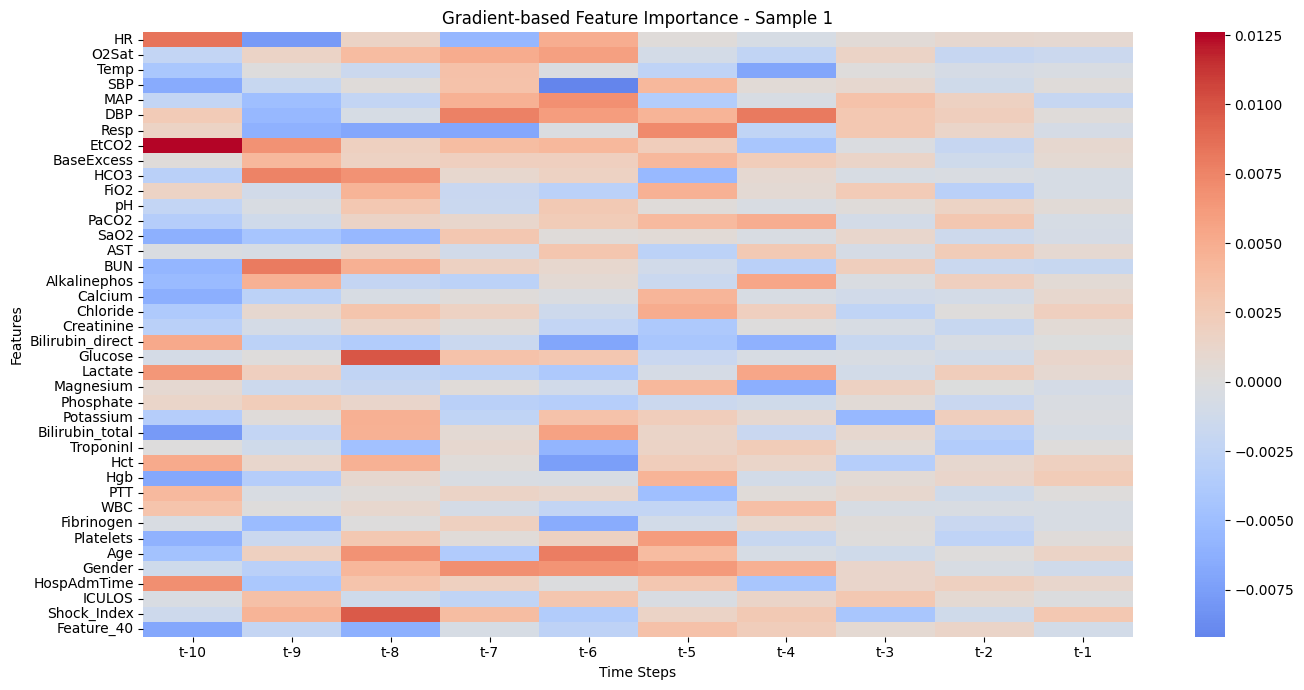

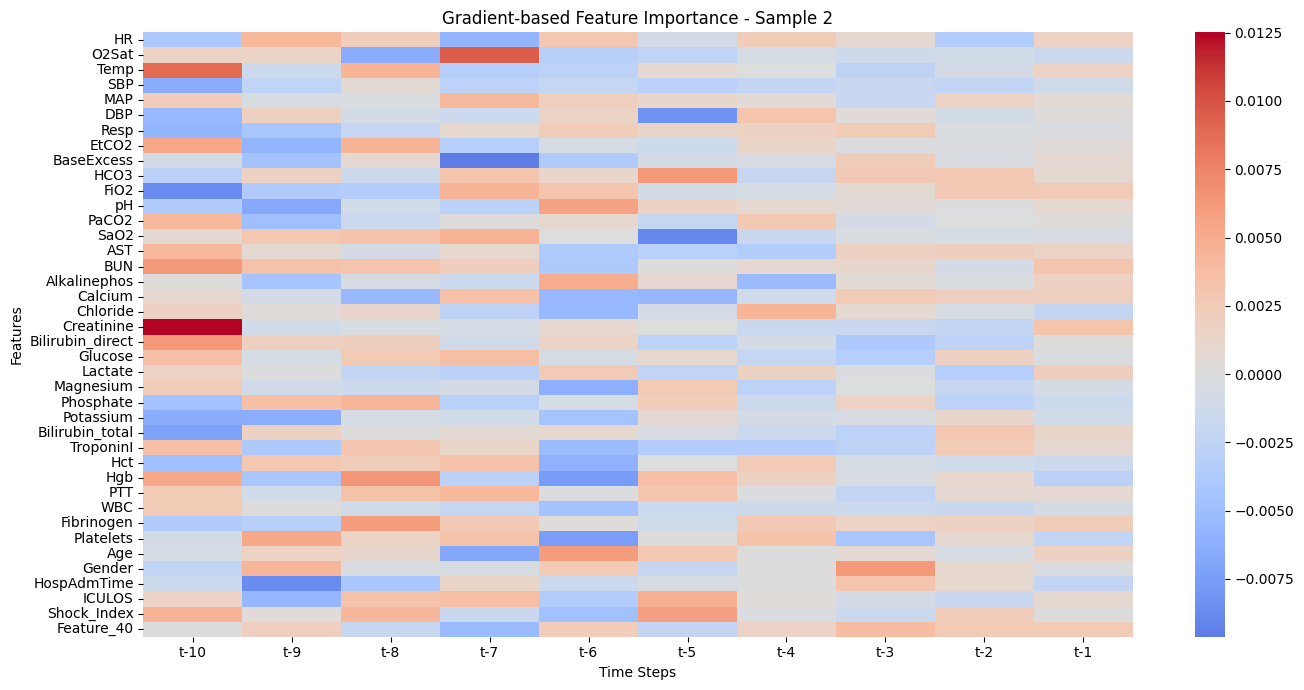

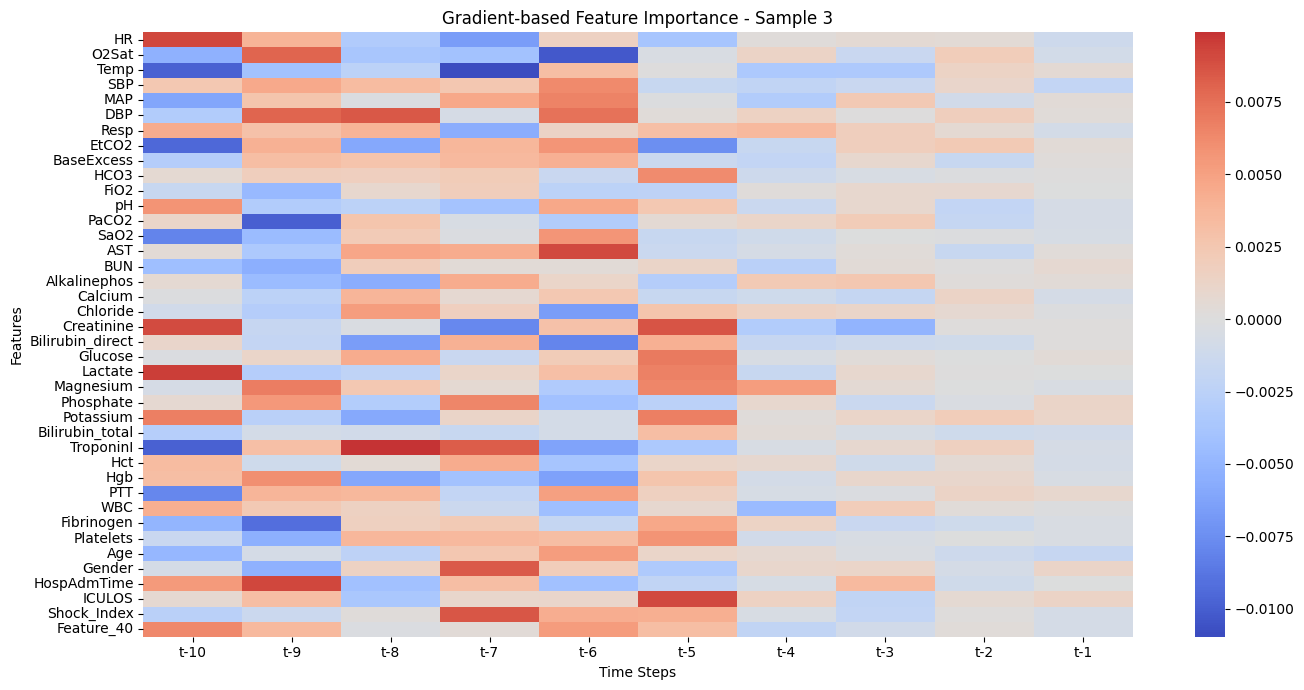

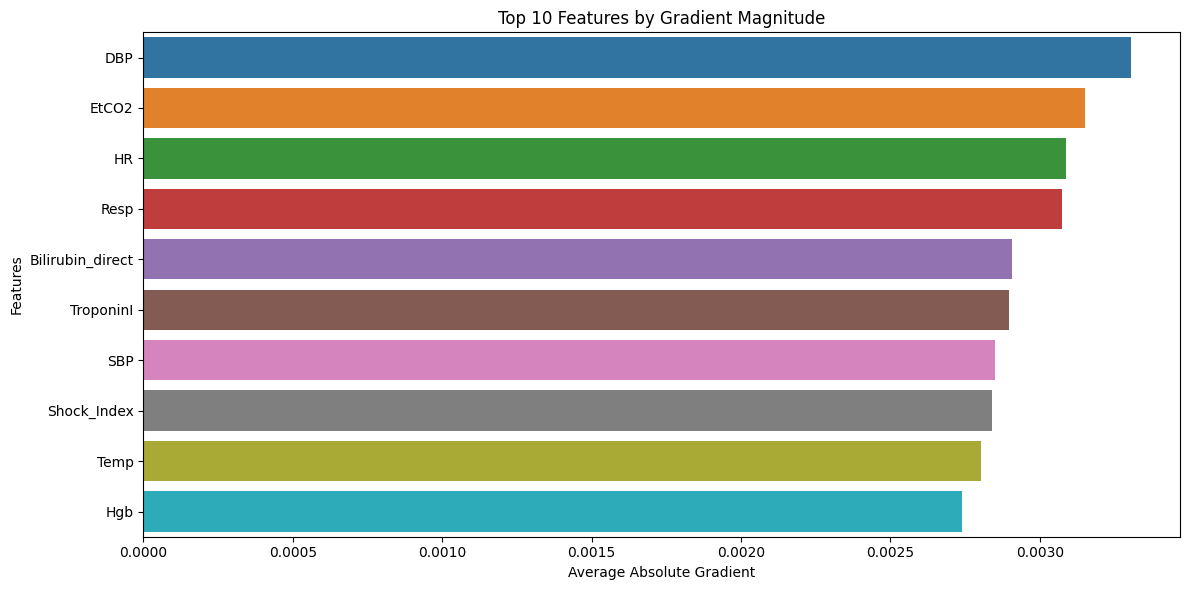

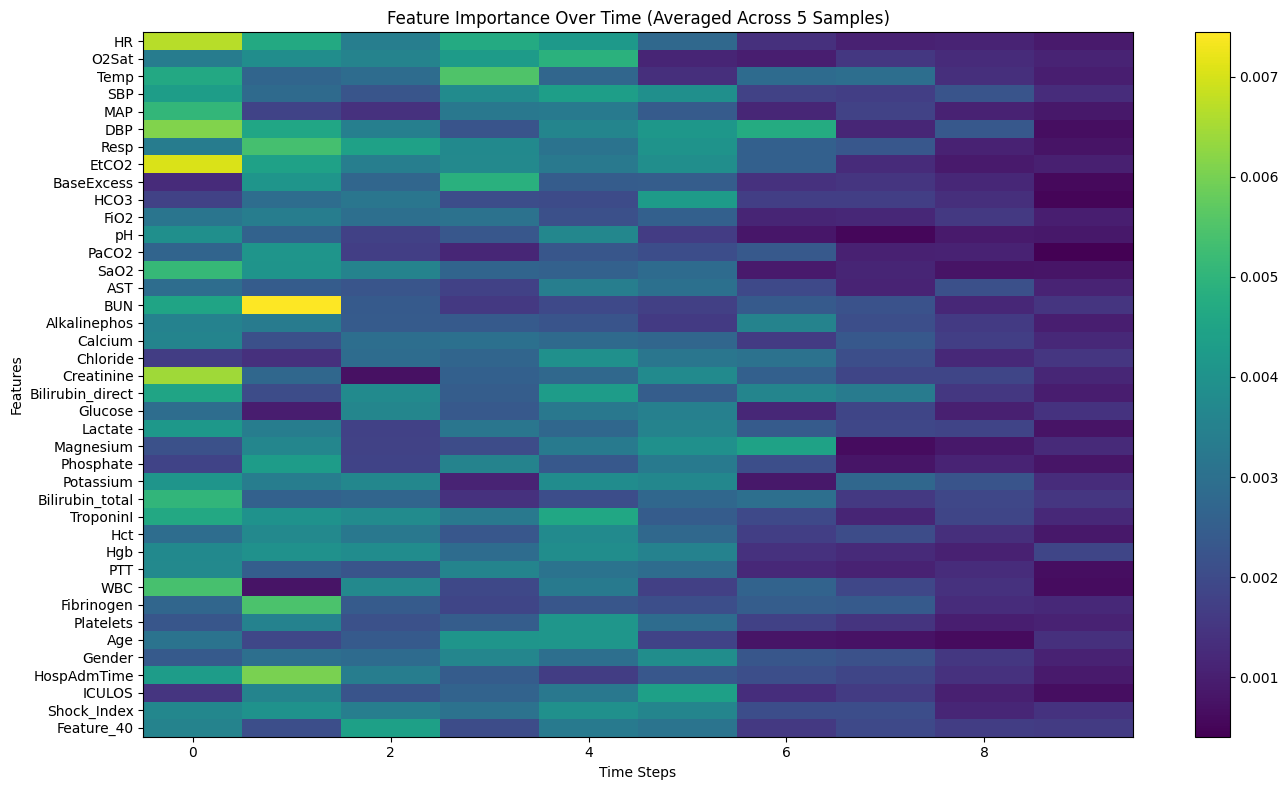

'\n# 2. To interpret with integrated gradients:\nig_importance = interpret_with_integrated_gradients(\n    model=your_tcn_model,\n    X=X_test,\n    feature_names=your_feature_names,\n    num_samples=5,\n    steps=20  # Integration steps\n)\n\n# 3. To interpret with saliency maps:\nsaliency_importance = interpret_with_saliency_maps(\n    model=your_tcn_model,\n    X=X_test,\n    feature_names=your_feature_names,\n    num_samples=5\n)\n\n# 4. To interpret with SHAP (if available):\nshap_explainer, shap_values = interpret_with_shap(\n    model=your_tcn_model,\n    X_background=X_train,  # Subset of training data\n    X_explain=X_test,      # Test data to explain\n    feature_names=your_feature_names,\n    num_samples=5\n)\n'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)


def get_feature_names(num_features):
    
   base_features = [
    'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 
    'EtCO2_measured', 'BaseExcess', 'HCO3_measured', 'FiO2', 
    'pH', 'PaCO2', 'SaO2_measured', 'AST_measured', 'BUN', 
    'Alkalinephos_measured', 'Calcium', 'Chloride_measured', 
    'Creatinine', 'Bilirubin_direct_measured', 'Glucose', 
    'Lactate_measured', 'Magnesium', 'Phosphate_measured', 
    'Potassium', 'Bilirubin_total_measured', 'TroponinI_measured', 
    'Hct', 'Hgb', 'PTT_measured', 'WBC', 'Fibrinogen_measured', 
    'Platelets', 'DBP_measured', 'Temp_observed', 'BaseExcess_observed', 
    'FiO2_observed', 'pH_observed', 'PaCO2_observed', 'BUN_observed', 
    'Calcium_observed', 'Creatinine_observed', 'Glucose_observed', 
    'Magnesium_observed', 'Potassium_observed', 'Hct_observed', 
    'Hgb_observed', 'WBC_observed', 'Platelets_observed', 
    'Unit1_observed', 'Unit2_observed'
     ]
   
   if num_features > len(base_features):
        for i in range(len(base_features), num_features):
            base_features.append(f"Feature_{i+1}")
    
 
   return base_features[:num_features]

def check_compatibility(model, data):
    
    model_shape = model.input_shape[1:]  
    data_shape = data.shape[1:]
    
    if model_shape != data_shape:
        print(f"WARNING: Data shape {data_shape} doesn't match model input shape {model_shape}")
        return False
    return True

def select_samples(X, num_samples=10):
    
    if len(X) > num_samples:
        sample_indices = np.random.choice(len(X), num_samples, replace=False)
        samples = X[sample_indices]
    else:
        samples = X
    return samples

# =================== GRADIENT-BASED METHOD ===================

def interpret_with_gradients(model, X, feature_names=None, num_samples=5, class_idx=1):
  
    print("\n===== Gradient-Based Interpretation =====")
    
    if not check_compatibility(model, X):
        print("Error: Model and data dimensions don't match!")
        return None
  
    if feature_names is None:
        feature_names = get_feature_names(X.shape[2])
    

    samples = select_samples(X, num_samples)
    print(f"Analyzing {len(samples)} samples using gradients")
  
    X_tensor = tf.convert_to_tensor(samples, dtype=tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(X_tensor)
        predictions = model(X_tensor)
        if class_idx == 1:
            target = predictions  # For positive class
        else:
            target = 1 - predictions  # For negative class
    
    gradients = tape.gradient(target, X_tensor).numpy()
    print(f"Gradient shape: {gradients.shape}")
    
  
    n_timesteps = gradients.shape[1]
    

    for i in range(min(3, len(samples))):
        plt.figure(figsize=(14, 7))
        sns.heatmap(gradients[i].T, cmap='coolwarm', center=0,
                  xticklabels=[f"t-{n_timesteps-t}" for t in range(n_timesteps)],
                  yticklabels=feature_names)
        plt.title(f"Gradient-based Feature Importance - Sample {i+1}")
        plt.xlabel("Time Steps")
        plt.ylabel("Features")
        plt.tight_layout()
        plt.show()
    
    avg_importance = np.mean(np.abs(gradients), axis=0)
    
   
    avg_feature_importance = np.mean(avg_importance, axis=0)
    top_indices = np.argsort(avg_feature_importance)[::-1][:10]
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=avg_feature_importance[top_indices], 
              y=[feature_names[j] for j in top_indices])
    plt.title("Top 10 Features by Gradient Magnitude")
    plt.xlabel("Average Absolute Gradient")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()
    
   
    plt.figure(figsize=(14, 8))
    im = plt.imshow(avg_importance.T, aspect='auto', cmap='viridis')
    plt.title(f"Feature Importance Over Time (Averaged Across {len(samples)} Samples)")
    plt.xlabel("Time Steps")
    plt.ylabel("Features")
    plt.yticks(range(len(feature_names)), feature_names)
    plt.colorbar(im)
    plt.tight_layout()
    plt.show()
    
    return avg_feature_importance

# ===================  INTEGRATED GRADIENTS METHOD ===================

def interpret_with_integrated_gradients(model, X, feature_names=None, num_samples=5, steps=20, class_idx=1):
    
    print("\n===== Integrated Gradients Interpretation =====")
    
    # Check compatibility
    if not check_compatibility(model, X):
        print("Error: Model and data dimensions don't match!")
        return None
    
  
    if feature_names is None:
        feature_names = get_feature_names(X.shape[2])
    
  
    samples = select_samples(X, num_samples)
    print(f"Analyzing {len(samples)} samples using integrated gradients with {steps} steps")

    baseline = np.zeros_like(samples)
    
    
    X_tensor = tf.convert_to_tensor(samples, dtype=tf.float32)
    baseline_tensor = tf.convert_to_tensor(baseline, dtype=tf.float32)
  
    alphas = tf.linspace(0.0, 1.0, steps+1)
    interpolated_inputs = [baseline_tensor + alpha * (X_tensor - baseline_tensor) for alpha in alphas]
    
    total_gradients = None
    
    for interp_input in interpolated_inputs:
        with tf.GradientTape() as tape:
            tape.watch(interp_input)
            predictions = model(interp_input)
            if class_idx == 1:
                target = predictions
            else:
                target = 1 - predictions
        
        gradients = tape.gradient(target, interp_input)
        
        if total_gradients is None:
            total_gradients = gradients
        else:
            total_gradients += gradients
    
    # Average gradients and multiply by (input - baseline)
    avg_gradients = total_gradients / steps
    integrated_grads = (X_tensor - baseline_tensor) * avg_gradients
    integrated_grads = integrated_grads.numpy()
    
    print(f"Integrated gradients shape: {integrated_grads.shape}")
    
    # Visualize results
    n_timesteps = integrated_grads.shape[1]
    
    # 1. Individual sample heatmaps
    for i in range(min(3, len(samples))):
        plt.figure(figsize=(14, 7))
        sns.heatmap(integrated_grads[i].T, cmap='coolwarm', center=0,
                  xticklabels=[f"t-{n_timesteps-t}" for t in range(n_timesteps)],
                  yticklabels=feature_names)
        plt.title(f"Integrated Gradients - Sample {i+1}")
        plt.xlabel("Time Steps")
        plt.ylabel("Features")
        plt.tight_layout()
        plt.show()
    
    # 2. Average importance
    avg_importance = np.mean(np.abs(integrated_grads), axis=0)
    
    # 3. Top features
    avg_feature_importance = np.mean(avg_importance, axis=0)
    top_indices = np.argsort(avg_feature_importance)[::-1][:10]
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=avg_feature_importance[top_indices], 
              y=[feature_names[j] for j in top_indices])
    plt.title("Top 10 Features by Integrated Gradients")
    plt.xlabel("Average Absolute Integrated Gradient")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()
    
    # 4. Temporal heatmap
    plt.figure(figsize=(14, 8))
    im = plt.imshow(avg_importance.T, aspect='auto', cmap='viridis')
    plt.title(f"Feature Importance Over Time (Integrated Gradients)")
    plt.xlabel("Time Steps")
    plt.ylabel("Features")
    plt.yticks(range(len(feature_names)), feature_names)
    plt.colorbar(im)
    plt.tight_layout()
    plt.show()
    
    return avg_feature_importance

# =================== SALIENCY MAPS METHOD ===================

def interpret_with_saliency_maps(model, X, feature_names=None, num_samples=5, class_idx=1):
  
    print("\n===== Saliency Map Interpretation =====")
    
    # Check compatibility
    if not check_compatibility(model, X):
        print("Error: Model and data dimensions don't match!")
        return None
    
    # Generate feature names if not provided
    if feature_names is None:
        feature_names = get_feature_names(X.shape[2])
    
    # Select samples
    samples = select_samples(X, num_samples)
    print(f"Analyzing {len(samples)} samples using saliency maps")
    
    # Compute gradients (similar to vanilla gradients but we take absolute value)
    X_tensor = tf.convert_to_tensor(samples, dtype=tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(X_tensor)
        predictions = model(X_tensor)
        if class_idx == 1:
            target = predictions
        else:
            target = 1 - predictions
    
    gradients = tape.gradient(target, X_tensor).numpy()
    saliency_maps = np.abs(gradients)  # Take absolute value for saliency
    
    print(f"Saliency maps shape: {saliency_maps.shape}")
    
    # Visualize results
    n_timesteps = saliency_maps.shape[1]
    for i in range(min(3, len(samples))):
        fig, axes = plt.subplots(2, 1, figsize=(14, 10))
        
        # Original input features
        im0 = axes[0].imshow(samples[i].T, aspect='auto', cmap='viridis')
        axes[0].set_title(f"Sample {i+1}: Original Input")
        axes[0].set_xlabel("Time Steps")
        axes[0].set_ylabel("Features")
        axes[0].set_yticks(range(len(feature_names)))
        axes[0].set_yticklabels(feature_names)
        plt.colorbar(im0, ax=axes[0])
        
        # Saliency map
        im1 = axes[1].imshow(saliency_maps[i].T, aspect='auto', cmap='hot')
        axes[1].set_title(f"Sample {i+1}: Saliency Map")
        axes[1].set_xlabel("Time Steps")
        axes[1].set_ylabel("Features")
        axes[1].set_yticks(range(len(feature_names)))
        axes[1].set_yticklabels(feature_names)
        plt.colorbar(im1, ax=axes[1])
        
        plt.tight_layout()
        plt.show()
    
    avg_saliency = np.mean(saliency_maps, axis=0)
    
    plt.figure(figsize=(14, 8))
    im = plt.imshow(avg_saliency.T, aspect='auto', cmap='hot')
    plt.title("Average Saliency Map Across All Samples")
    plt.xlabel("Time Steps")
    plt.ylabel("Features")
    plt.yticks(range(len(feature_names)), feature_names)
    plt.colorbar(im)
    plt.tight_layout()
    plt.show()
    
    avg_feature_saliency = np.mean(avg_saliency, axis=0)
    top_indices = np.argsort(avg_feature_saliency)[::-1][:10]
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=avg_feature_saliency[top_indices], y=[feature_names[j] for j in top_indices])
    plt.title("Top 10 Features by Saliency")
    plt.xlabel("Average Saliency")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()
    
    return avg_feature_saliency

# =================== SHAP ANALYSIS  ===================

def interpret_with_shap(model, X_background, X_explain, feature_names=None, num_samples=5):
  
    print("\n===== SHAP Interpretation =====")
    
    try:
        import shap
    except ImportError:
        print("SHAP library not installed. Please install with: pip install shap")
        return None, None
    
    if not check_compatibility(model, X_background) or not check_compatibility(model, X_explain):
        print("Error: Model and data dimensions don't match!")
        return None, None
    
    if feature_names is None:
        feature_names = get_feature_names(X_explain.shape[2])
    
    if len(X_background) > 100:
        idx = np.random.choice(len(X_background), size=100, replace=False)
        background = X_background[idx]
    else:
        background = X_background
  
    samples = select_samples(X_explain, num_samples)
    print(f"Analyzing {len(samples)} samples using SHAP with {len(background)} background samples")
    
   
    explainer = shap.GradientExplainer(model, background)
    
  
    shap_values = explainer.shap_values(samples)
    
    if isinstance(shap_values, list):
        shap_values = shap_values[0]  # For binary classification
    
    print(f"SHAP values shape: {shap_values.shape}")
    
    n_timesteps = shap_values.shape[1]
    n_features = shap_values.shape[2]
    
  
    for i in range(min(3, len(samples))):
        plt.figure(figsize=(14, 7))
        sns.heatmap(shap_values[i].T, cmap='coolwarm', center=0,
                  xticklabels=[f"t-{n_timesteps-t}" for t in range(n_timesteps)],
                  yticklabels=feature_names)
        plt.title(f"SHAP Values - Sample {i+1}")
        plt.xlabel("Time Steps")
        plt.ylabel("Features")
        plt.tight_layout()
        plt.show()
    
    
    X_explain_flat = samples.reshape(samples.shape[0], -1)
    shap_values_flat = shap_values.reshape(shap_values.shape[0], -1)
    
    feature_names_with_time = []
    for t in range(n_timesteps):
        for f in feature_names:
            feature_names_with_time.append(f"{f} (t-{n_timesteps-t})")
    
    # SHAP summary plot (top 20 features)
    plt.figure(figsize=(12, 8))
    shap.summary_plot(
        shap_values_flat, X_explain_flat, 
        feature_names=feature_names_with_time,
        max_display=20, plot_size=(12, 8), show=False
    )
    plt.title("SHAP Summary Plot (Top 20 Features)")
    plt.tight_layout()
    plt.show()
    
    avg_importance = np.mean(np.abs(shap_values), axis=(0, 1))  # Average across samples and time
    top_indices = np.argsort(avg_importance)[::-1][:10]  # Top 10 features
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=avg_importance[top_indices], y=[feature_names[j] for j in top_indices])
    plt.title("Top 10 Features by Average SHAP Value")
    plt.xlabel("Average |SHAP Value|")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()
    
    return explainer, shap_values


# To interpret with vanilla gradients
gradient_importance = interpret_with_gradients(
    model=model,
    X=X_test,  
    
    num_samples=5 
)




===== Integrated Gradients Interpretation =====
Analyzing 5 samples using integrated gradients with 20 steps
Integrated gradients shape: (5, 10, 40)


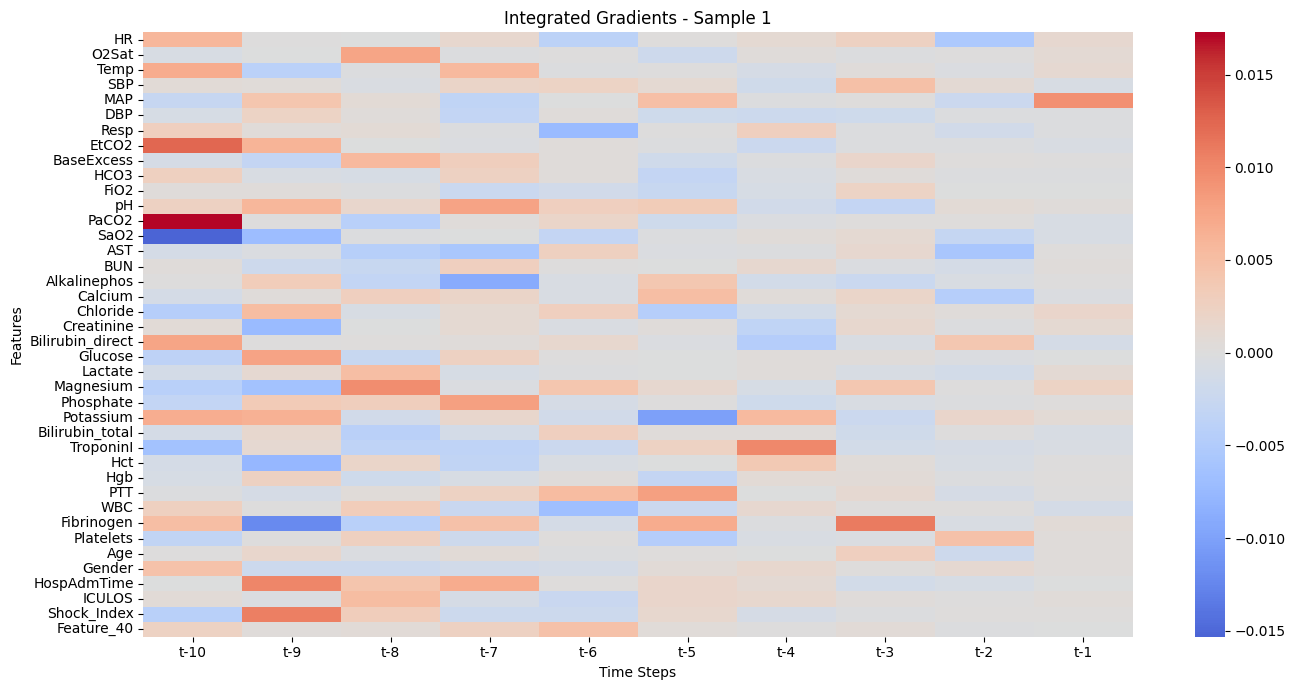

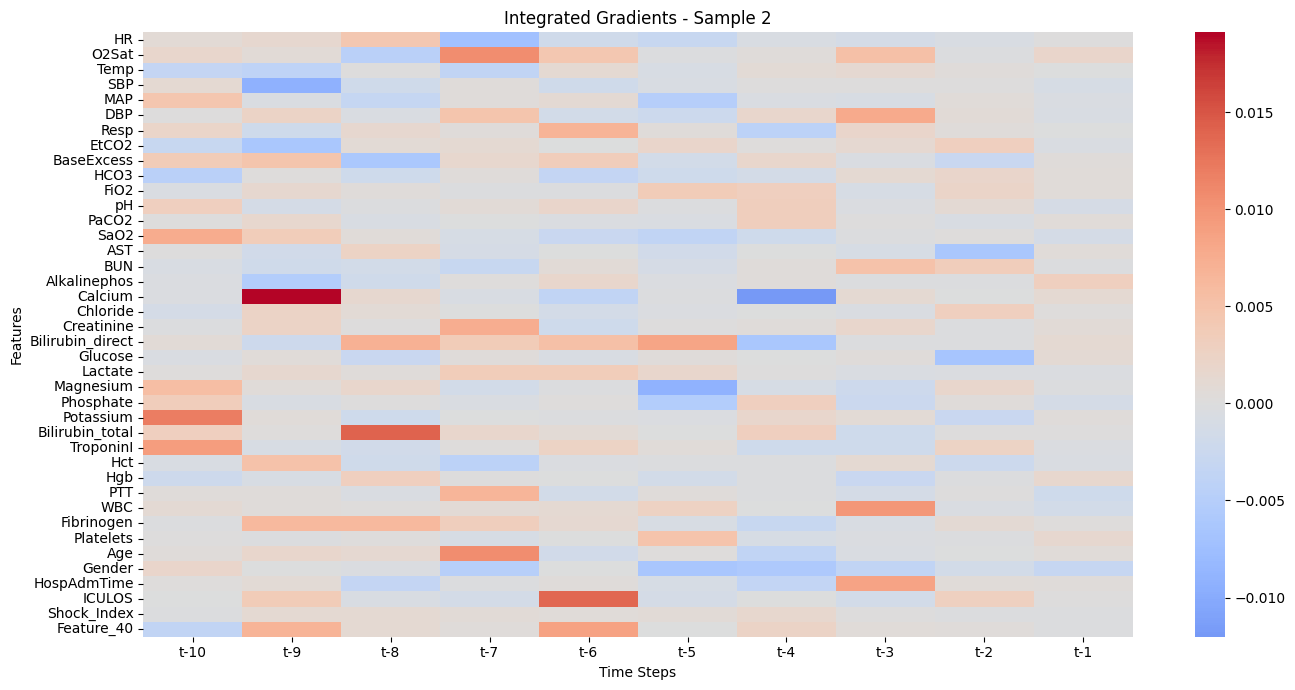

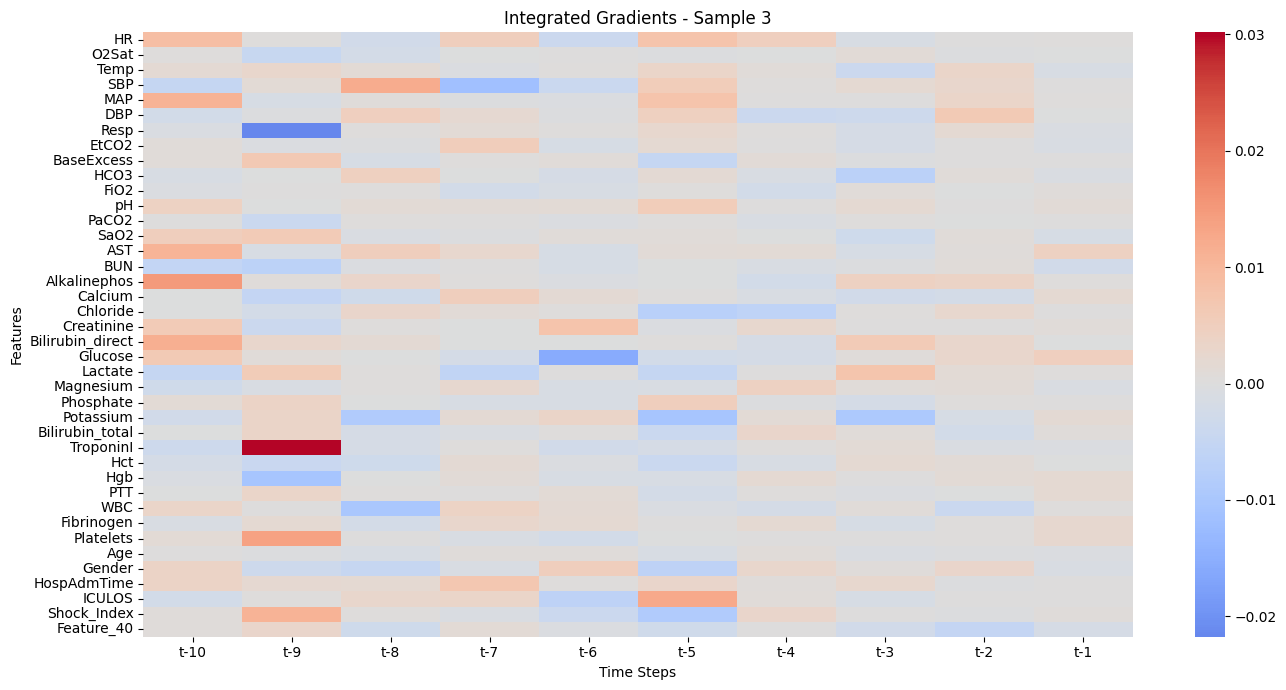

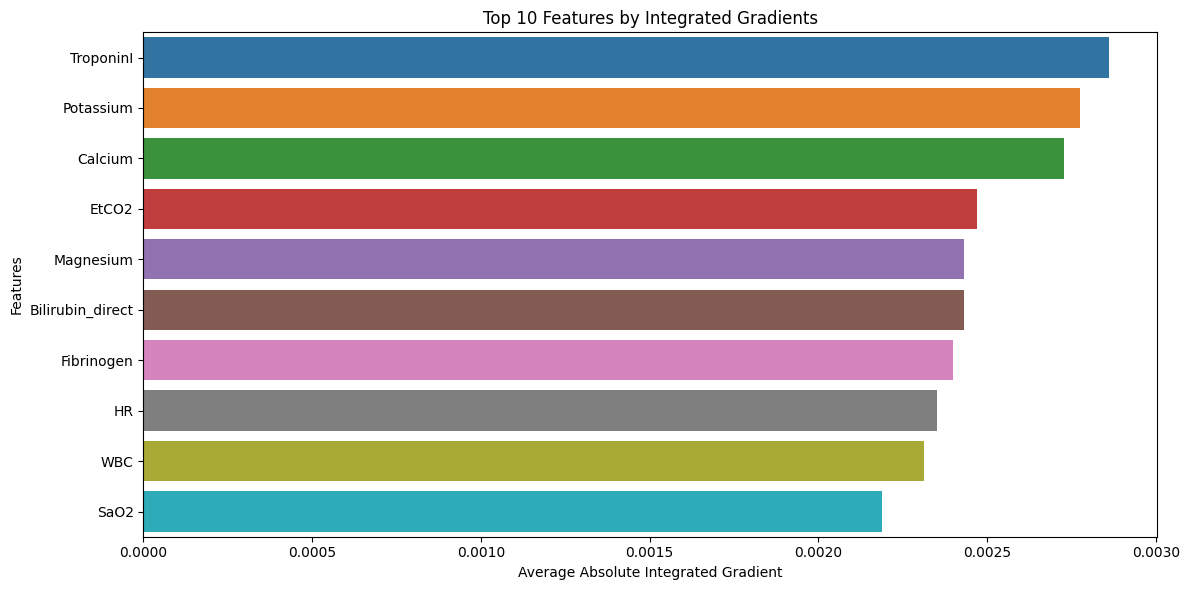

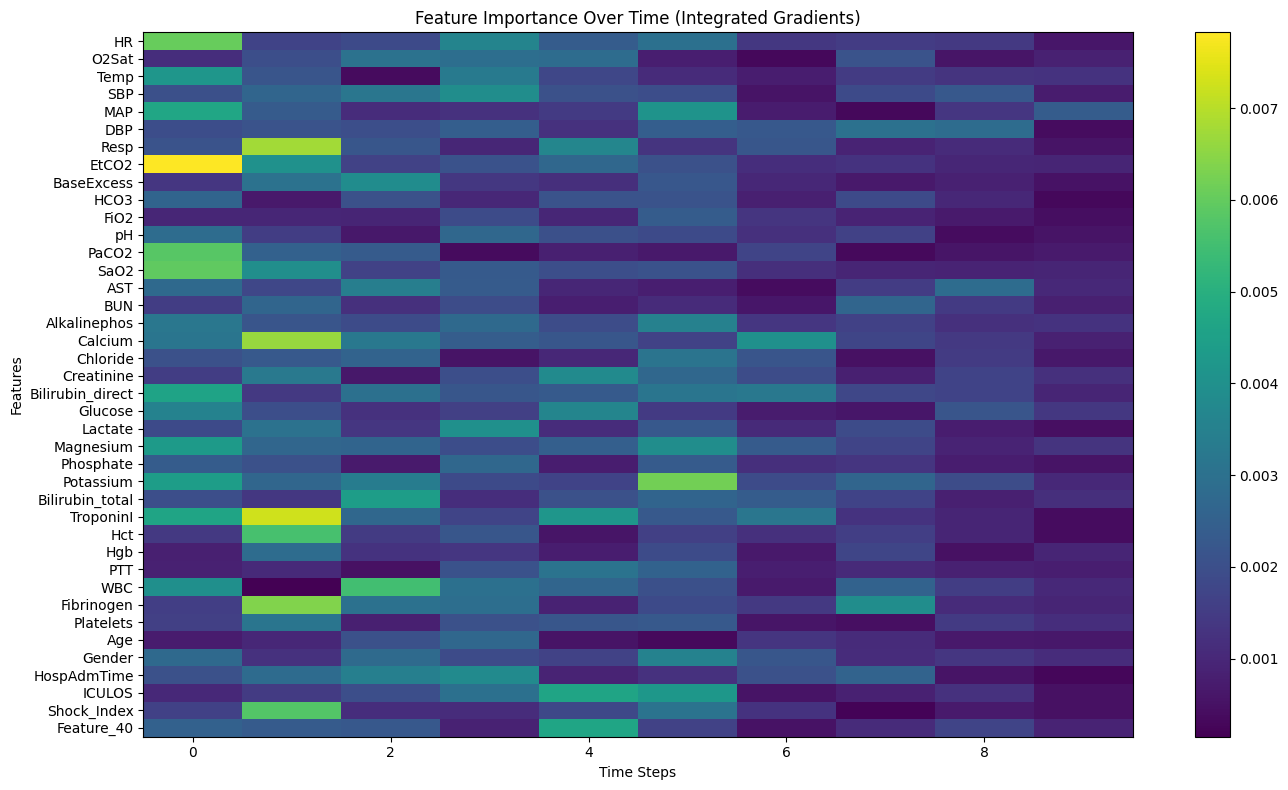

In [40]:

# interpret with integrated gradients:
ig_importance = interpret_with_integrated_gradients(
    model=model,
    X=X_test,
    
    num_samples=5,
    steps=20  # Integration steps
)




===== Saliency Map Interpretation =====
Analyzing 5 samples using saliency maps
Saliency maps shape: (5, 10, 40)


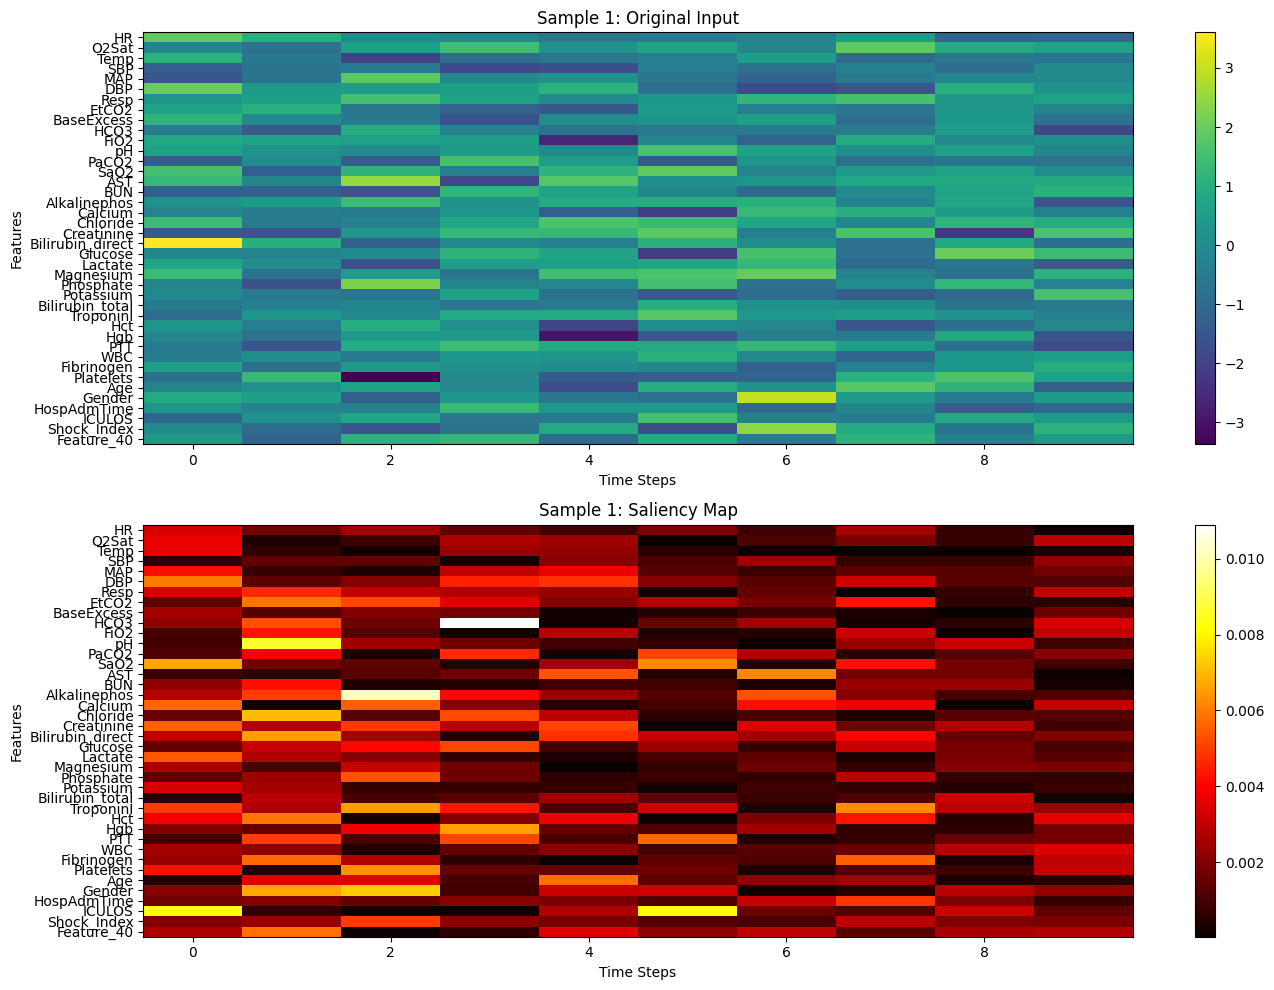

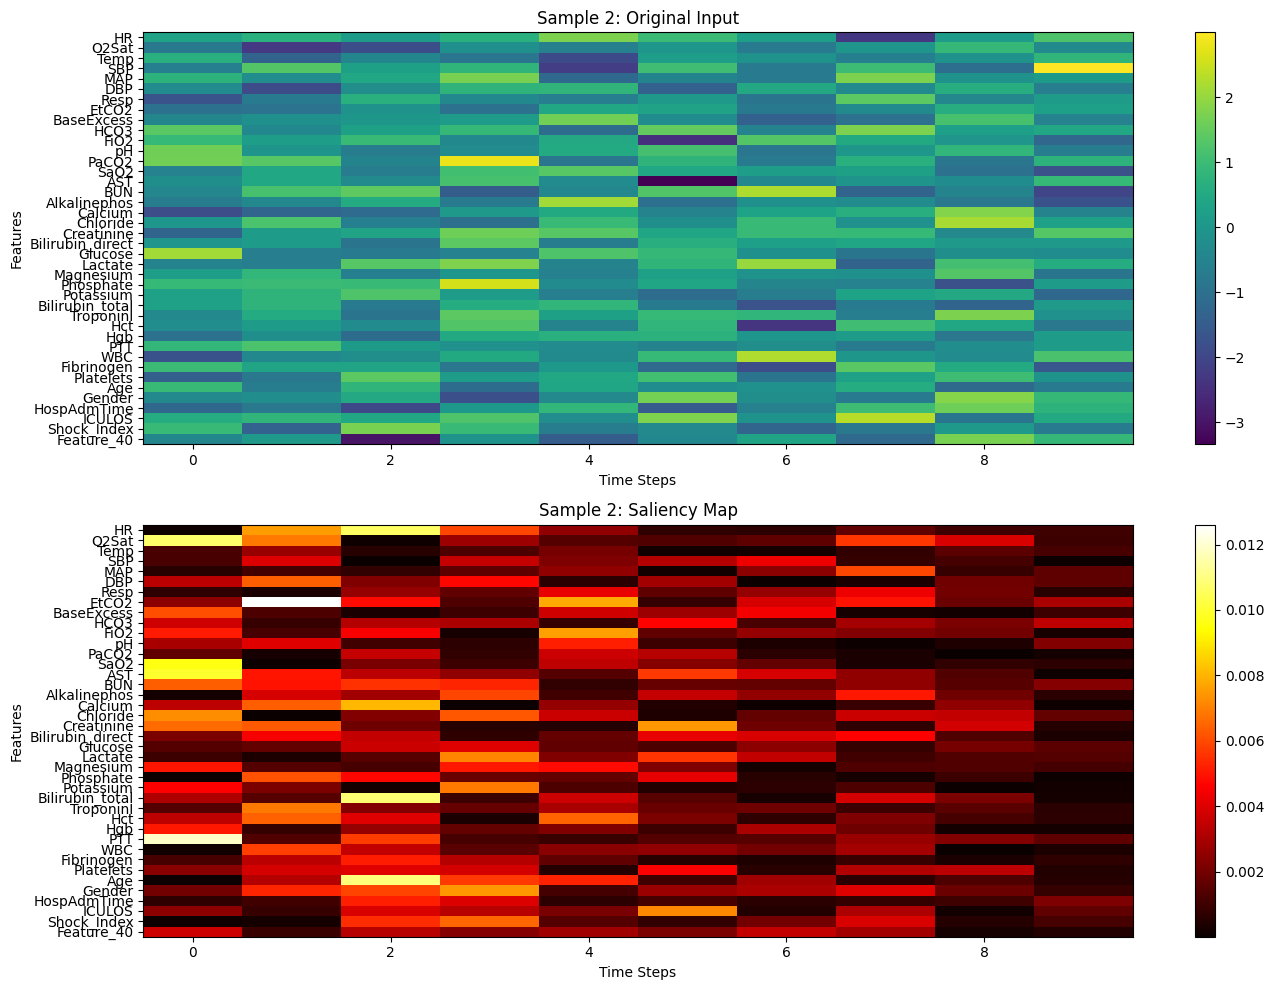

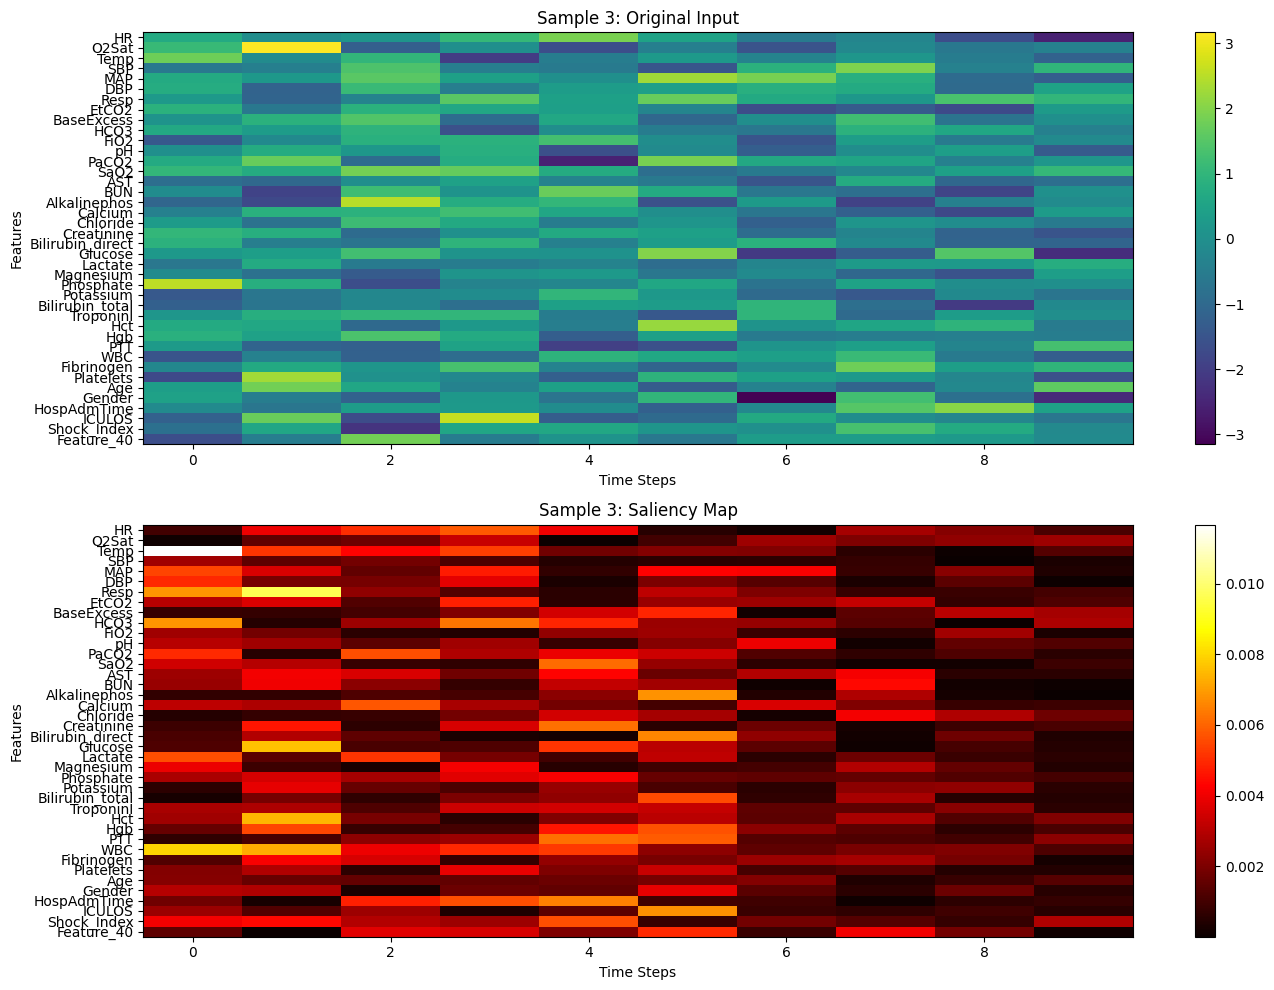

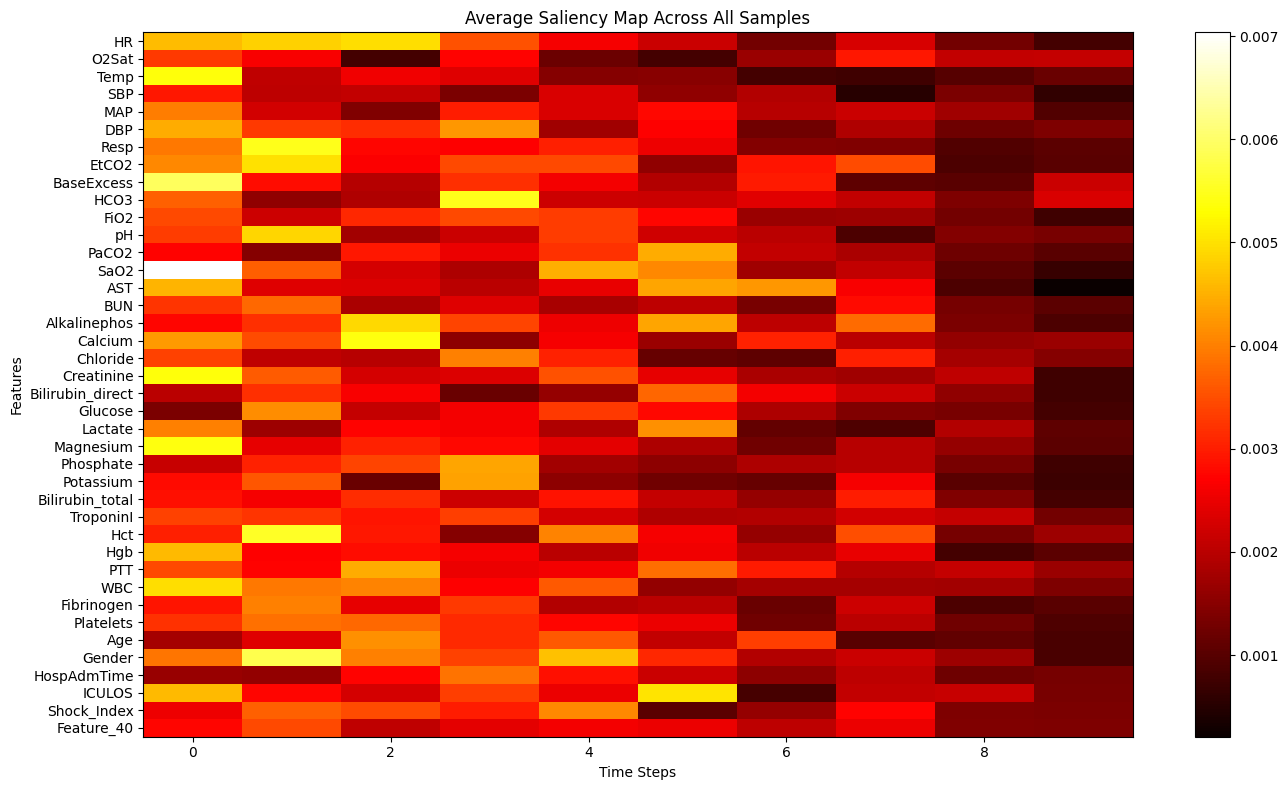

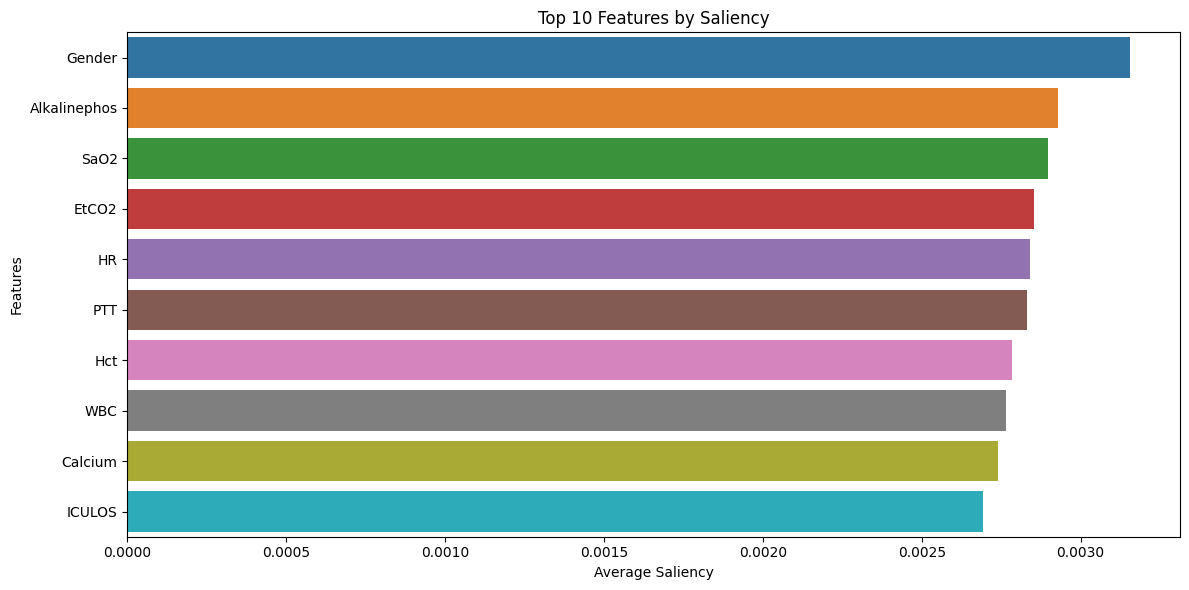

In [41]:
#  To interpret with saliency maps:
saliency_importance = interpret_with_saliency_maps(
    model=model,
    X=X_test,
   
    num_samples=5
)




In [ ]:
shap_importance = interpret_with_shap(
    model=model,
    X=X_test, 
    
    num_samples=5  
)